In [1]:
import pickle
import json
import os
import re
import sys
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
import tifffile
import yaml
from matplotlib.collections import PolyCollection
from matplotlib.colors import TwoSlopeNorm
from einops import rearrange, repeat
from pydantic_extra_types.color import Color

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
from mushroom.mushroom import Mushroom, DEFAULT_CONFIG
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.data.multiplex as multiplex
import mushroom.data.visium as visium
import mushroom.data.xenium as xenium
import mushroom.data.cosmx as cosmx
import mushroom.visualization.tiling_utils as tiling_utils

In [6]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

In [7]:
run_dir = '/data/estorrs/mushroom/data/projects/submission_v1'

In [8]:
def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
        
    return config

In [477]:
# case = 'HT913Z1'
# case = 'HT891Z1'
# case = 'HT704B1'
# case = 'HT206B1'
case = 'HT397B1'
# case = 'HT413C1-Th1k4A1'
# case = 'HT268B1'
# case = 'HT339B2-H1'
# case = 'HT565B1-H2'
# case = 'S18-5591-C8'
# case = 'S18-9906'

In [478]:
project_dir = Path(f'/data/estorrs/mushroom/data/projects/submission_v1/{case}')

In [479]:
fig_dir = project_dir / 'figures' 
fig_dir.mkdir(parents=True, exist_ok=True)

In [480]:
config = yaml.safe_load(open(os.path.join(project_dir, 'registered', 'metadata.yaml')))
config = alter_filesystem(config, source_root, target_root)
config

{'resolution': 1.0,
 'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s0_HT397B1-U1_visium_scaled.h5ad'},
    {'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s0_HT397B1-U1_he_scaled.tif'}],
   'position': 0,
   'sid': 'HT397B1-U1'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s1_HT397B1-U2_multiplex_scaled.ome.tiff'}],
   'position': 5,
   'sid': 'HT397B1-U2'},
  {'data': [{'dtype': 'batch2_he',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s2_HT397B1-U4_batch2_he_scaled.tif'}],
   'position': 15,
   'sid': 'HT397B1-U4'},
  {'data': [{'dtype': 'batch2_he',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s3_HT397B1-U8_batch2_he_scaled.tif'}],
   'position': 35,
   'sid': 'HT397B1-U8'},
  {'dat

In [481]:
sid_to_z = {entry['sid']:i for i, entry in enumerate(config['sections'])}

In [482]:
imaris_dir = project_dir / 'imaris' / 'rois'
imaris_dir.mkdir(parents=True, exist_ok=True)

In [483]:
full_rgb_dir = imaris_dir / 'full_rgbs'
full_rgb_dir.mkdir(parents=True, exist_ok=True)

## case specific data gen

###### saving full stack rgbs

In [16]:
pseudos_rgb_dir = imaris_dir / 'pseudos_rgbs_zlabeled'
pseudos_rgb_dir.mkdir(parents=True, exist_ok=True)

full_rgb_dir = imaris_dir / 'full_rgbs'
full_rgb_dir.mkdir(parents=True, exist_ok=True)

full_rgb_no_dir = imaris_dir / 'full_rgbs_no_overlays'
full_rgb_no_dir.mkdir(parents=True, exist_ok=True)

In [17]:
case_to_multiplex_view_settings = {
    'HT913Z1': [
        {
            'channel': 'E-Cadherin',
            'color': 'red',
            'min_value': 15,
            'max_value': 100,
            'gamma': 1.
        },
        {
            'channel': 'HLA-DR',
            'color': 'yellow',
            'min_value': 15,
            'max_value': 255,
            'gamma': 1.
        },
        {
            'channel': 'CK5',
            'color': 'white',
            'min_value': 15,
            'max_value': 255,
            'gamma': 1.
        },
        {
            'channel': 'CD3e',
            'color': 'green',
            'min_value': 20,
            'max_value': 75,
            'gamma': 1.
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'min_value': 15,
            'max_value': 255,
            'gamma': 1.
        },
    ],
    'HT891Z1': [
        {
            'channel': 'E-Cadherin',
            'color': 'red',
            'min_value': 15,
            'max_value': 100,
            'gamma': 1.
        },
        {
            'channel': 'HLA-DR',
            'color': 'yellow',
            'min_value': 15,
            'max_value': 255,
            'gamma': 1.
        },
        {
            'channel': 'CK5',
            'color': 'white',
            'min_value': 15,
            'max_value': 255,
            'gamma': 1.
        },
        {
            'channel': 'CD3e',
            'color': 'green',
            'min_value': 20,
            'max_value': 255,
            'gamma': 1.
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'min_value': 15,
            'max_value': 255,
            'gamma': 1.
        },
    ],
    'HT704B1': [
        {
            'channel': 'Pan-Cytokeratin',
            'color': 'red',
            'min_value': 15,
            'max_value': 100,
            'gamma': 1.
        },
        {
            'channel': 'HLA-DR',
            'color': 'yellow',
            'min_value': 15,
            'max_value': 255,
            'gamma': 1.
        },
        {
            'channel': 'Keratin 5',
            'color': 'white',
            'min_value': 15,
            'max_value': 255,
            'gamma': 1.
        },
        {
            'channel': 'CD3e',
            'color': 'green',
            'min_value': 20,
            'max_value': 255,
            'gamma': 1.
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'min_value': 15,
            'max_value': 255,
            'gamma': 1.
        },
    ],
    'HT206B1': [
        {
            'channel': 'Pan-Cytokeratin',
            'color': 'red',
            'min_value': 15,
            'max_value': 100,
            'gamma': 1.
        },
        {
            'channel': 'HLA-DR',
            'color': 'yellow',
            'min_value': 15,
            'max_value': 150,
            'gamma': 1.
        },
        {
            'channel': 'SMA (D)',
            'color': 'white',
            'min_value': 15,
            'max_value': 150,
            'gamma': 1.
        },
        {
            'channel': 'Podoplanin (D)',
            'color': 'white',
            'min_value': 15,
            'max_value': 65,
            'gamma': 1.
        },
        {
            'channel': 'CD4 (D)',
            'color': 'green',
            'min_value': 20,
            'max_value': 165,
            'gamma': 1.
        },
        {
            'channel': 'CD45 (D)',
            'color': 'cyan',
            'min_value': 40,
            'max_value': 130,
            'gamma': 1.
        },
    ],
    'HT397B1': [
        {
            'channel': 'Pan-Cytokeratin',
            'color': 'red',
            'min_value': 15,
            'max_value': 255,
            'gamma': 1.
        },
        {
            'channel': 'HLA-DR',
            'color': 'yellow',
            'min_value': 20,
            'max_value': 255,
            'gamma': 1.
        },
        {
            'channel': 'Keratin 14',
            'color': 'white',
            'min_value': 25,
            'max_value': 100,
            'gamma': 1.
        },
        {
            'channel': 'CD8',
            'color': 'green',
            'min_value': 10,
            'max_value': 31,
            'gamma': 1.
        },
        {
            'channel': 'CD45 (D)',
            'color': 'cyan',
            'min_value': 15,
            'max_value': 35,
            'gamma': 1.
        },
    ],
    'HT339B2-H1': [
        {
            'channel': 'Pan-Cytokeratin',
            'color': 'red',
            'min_value': 10,
            'max_value': 40,
            'gamma': 1.
        },
        {
            'channel': 'HLA-DR',
            'color': 'yellow',
            'min_value': 10,
            'max_value': 120,
            'gamma': 1.
        },
        {
            'channel': 'Keratin 5',
            'color': 'white',
            'min_value': 10,
            'max_value': 120,
            'gamma': 1.
        },
        {
            'channel': 'CD8',
            'color': 'green',
            'min_value': 10,
            'max_value': 90,
            'gamma': 1.
        },
        {
            'channel': 'CD4',
            'color': 'cyan',
            'min_value': 20,
            'max_value': 90,
            'gamma': 1.
        },
    ],
    'HT565B1-H2': [
        {
            'channel': 'Pan-Cytokeratin',
            'color': 'red',
            'min_value': 10,
            'max_value': 40,
            'gamma': 1.
        },
        {
            'channel': 'HLA-DR',
            'color': 'yellow',
            'min_value': 10,
            'max_value': 120,
            'gamma': 1.
        },
        {
            'channel': 'Keratin 5',
            'color': 'white',
            'min_value': 10,
            'max_value': 120,
            'gamma': 1.
        },
        {
            'channel': 'CD8',
            'color': 'green',
            'min_value': 10,
            'max_value': 90,
            'gamma': 1.
        },
        {
            'channel': 'CD4',
            'color': 'cyan',
            'min_value': 20,
            'max_value': 90,
            'gamma': 1.
        },
    ],
    'S18-5591-C8': [
        {
            'channel': 'CK8/18',
            'color': 'red',
            'min_value': 10,
            'max_value': 255,
            'gamma': 1.
        },
        {
            'channel': 'HLA-DR',
            'color': 'yellow',
            'min_value': 10,
            'max_value': 180,
            'gamma': 1.
        },
        {
            'channel': 'CK5',
            'color': 'white',
            'min_value': 10,
            'max_value': 120,
            'gamma': 1.
        },
        {
            'channel': 'CD3e',
            'color': 'green',
            'min_value': 10,
            'max_value': 40,
            'gamma': 1.
        },
        {
            'channel': 'CD4',
            'color': 'cyan',
            'min_value': 10,
            'max_value': 70,
            'gamma': 1.
        },
    ],
    'S18-9906': [
        {
            'channel': 'Pan-Cytokeratin',
            'color': 'red',
            'min_value': 10,
            'max_value': 120,
            'gamma': 1.
        },
        {
            'channel': 'HLA-DR',
            'color': 'yellow',
            'min_value': 10,
            'max_value': 200,
            'gamma': 1.
        },
        {
            'channel': 'CK5',
            'color': 'white',
            'min_value': 10,
            'max_value': 120,
            'gamma': 1.
        },
        {
            'channel': 'CD3e',
            'color': 'green',
            'min_value': 10,
            'max_value': 100,
            'gamma': 1.
        },
        {
            'channel': 'CD4',
            'color': 'cyan',
            'min_value': 10,
            'max_value': 100,
            'gamma': 1.
        },
    ],
    'HT413C1-Th1k4A1': [
        {
            'channel': 'PanCytokeratin',
            'color': 'red',
            'min_value': 10,
            'max_value': 120,
            'gamma': 1.
        },
        {
            'channel': 'HLA-DR',
            'color': 'yellow',
            'min_value': 10,
            'max_value': 200,
            'gamma': 1.
        },
        {
            'channel': 'SMA (D)',
            'color': 'white',
            'min_value': 10,
            'max_value': 120,
            'gamma': 1.
        },
        {
            'channel': 'CD3e (D)',
            'color': 'green',
            'min_value': 10,
            'max_value': 100,
            'gamma': 1.
        },
        {
            'channel': 'CD68 (D)',
            'color': 'cyan',
            'min_value': 10,
            'max_value': 100,
            'gamma': 1.
        },
    ],
  
}

In [18]:

multiplex_view_settings = case_to_multiplex_view_settings.get(case)

def get_multiplex_pseudo(fp, view_settings):
    channels = [x['channel'] for x in view_settings]
    colors = [x['color'] for x in view_settings]
    min_values = [x['min_value'] for x in view_settings]
    max_values = [x['max_value'] for x in view_settings]
    gammas = [x['gamma'] for x in view_settings]
    
    channel_to_img = multiplex.extract_ome_tiff(fp, as_dict=True)
    print(channel_to_img.keys())
    data = np.stack([channel_to_img[x] for x in channels])
    
    rgb = multiplex.to_pseudocolor(
        data,
        colors=colors,
        min_values=min_values,
        max_values=max_values,
        gammas=gammas
    )
    
    rgb *= 255.
    rgb = rgb.astype(np.uint8)
    
    return rgb

In [19]:
XENIUM_FOCUS_SETTINGS = [
    {
        'channel': 'DAPI',
        'color': 'blue',
        'min_value': 0,
        'max_value': 100,
        'gamma': 1.
    },
    {
        'channel': 'ATP1A1/CD45/E-Cadherin',
        'color': 'magenta',
        'min_value': 0,
        'max_value': 100,
        'gamma': 1.
    },
                         {
        'channel': '18S',
        'color': 'yellow',
        'min_value': 0,
        'max_value': 50,
        'gamma': 1.
    },
                         {
        'channel': 'alphaSMA/Vimentin',
        'color': 'green',
        'min_value': 0,
        'max_value': 100,
        'gamma': 1.
    },
]

case_to_xenium_view_settings = {
    'HT913Z1': [
        {
            'channel': 'EPCAM',
            'color': 'red',
            'marker': '.',
        },
        {
            'channel': 'HLA-DQB2',
            'color': 'yellow',
            'marker': 'v',
        },
        {
            'channel': 'TP63',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'KRT5',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'CP',
            'color': 'purple',
            'marker': 'P',
        },
        {
            'channel': 'CD3E',
            'color': 'limegreen',
            'marker': '*',
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'marker': 'D',
        },
    ],
    'HT891Z1': [
        {
            'channel': 'EPCAM',
            'color': 'red',
            'marker': '.',
        },
        {
            'channel': 'HLA-DQB2',
            'color': 'yellow',
            'marker': 'v',
        },
        {
            'channel': 'TP63',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'KRT5',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'CP',
            'color': 'purple',
            'marker': 'P',
        },
        {
            'channel': 'CD3E',
            'color': 'limegreen',
            'marker': '*',
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'marker': 'D',
        },
    ],
    'HT704B1': [
        {
            'channel': 'EPCAM',
            'color': 'red',
            'marker': '.',
        },
        {
            'channel': 'HLA-DQB2',
            'color': 'yellow',
            'marker': 'v',
        },
        {
            'channel': 'KRT5',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'TP63',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'CD3E',
            'color': 'limegreen',
            'marker': '*',
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'marker': 'D',
        },
    ],
    'HT206B1': [
        {
            'channel': 'EPCAM',
            'color': 'red',
            'marker': '.',
        },
        {
            'channel': 'HLA-DQB2',
            'color': 'yellow',
            'marker': 'v',
        },
        {
            'channel': 'ACTA2',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'PDPN',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'CD3E',
            'color': 'limegreen',
            'marker': '*',
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'marker': 'D',
        },
    ],
    'HT397B1': [
        {
            'channel': 'EPCAM',
            'color': 'red',
            'marker': '.',
        },
        {
            'channel': 'HLA-DQB2',
            'color': 'yellow',
            'marker': 'v',
        },
        {
            'channel': 'KRT5',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'CD3E',
            'color': 'limegreen',
            'marker': '*',
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'marker': 'D',
        },
    ],
    'S18-5591-C8': [
        {
            'channel': 'EPCAM',
            'color': 'red',
            'marker': '.',
        },
        {
            'channel': 'HLA-DQB2',
            'color': 'yellow',
            'marker': 'v',
        },
        {
            'channel': 'TP63',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'KRT5',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'CP',
            'color': 'purple',
            'marker': 'P',
        },
        {
            'channel': 'CD3E',
            'color': 'limegreen',
            'marker': '*',
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'marker': 'D',
        },
    ],
    'S18-9906': [
        {
            'channel': 'EPCAM',
            'color': 'red',
            'marker': '.',
        },
        {
            'channel': 'HLA-DQB2',
            'color': 'yellow',
            'marker': 'v',
        },
        {
            'channel': 'TP63',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'KRT5',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'CP',
            'color': 'purple',
            'marker': 'P',
        },
        {
            'channel': 'CD3E',
            'color': 'limegreen',
            'marker': '*',
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'marker': 'D',
        },
    ],
    'HT413C1-Th1k4A1': [
        {
            'channel': 'EPCAM',
            'color': 'red',
            'marker': '.',
        },
        {
            'channel': 'HLA-DQB2',
            'color': 'yellow',
            'marker': 'v',
        },
        {
            'channel': 'ACTA2',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'HEPN1',
            'color': 'purple',
            'marker': 'P',
        },
        {
            'channel': 'CD3E',
            'color': 'limegreen',
            'marker': '*',
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'marker': 'D',
        },
    ],
}

xenium_view_settings = case_to_xenium_view_settings.get(case)

def get_xenium_pseudo(morph_fp, focus_settings):
    cs = multiplex.get_ome_tiff_channels(morph_fp)
    if len(cs) == 1: # just nuclei
        channels = ['DAPI']
        colors = ['white']
        min_values = [0.]
        max_values = [100.]
        gammas = [1.]
    else: # multiple channels
        channels = [x['channel'] for x in focus_settings]
        colors = [x['color'] for x in focus_settings]
        min_values = [x['min_value'] for x in focus_settings]
        max_values = [x['max_value'] for x in focus_settings]
        gammas = [x['gamma'] for x in focus_settings]
    
    channel_to_img = multiplex.extract_ome_tiff(morph_fp, as_dict=True)
    data = np.stack([channel_to_img[x] for x in channels])
    
    rgb = multiplex.to_pseudocolor(
        data,
        colors=colors,
        min_values=min_values,
        max_values=max_values,
        gammas=gammas
    )
    
    rgb *= 255.
    rgb = rgb.astype(np.uint8)
    
    return rgb

def plot_xenium_pseudo(ax, rgb, transcripts, view_settings, s=.1):
    ax.imshow(rgb)
    
    if not isinstance(transcripts, pd.DataFrame):
        transcripts = pd.read_parquet(transcripts)
        
    pool = set(transcripts['feature_name'])
    for entry in view_settings:
        color = np.asarray(Color(entry['color']).as_rgb_tuple()) / 255.
        channel = entry['channel']
        marker = entry['marker']
        
        if channel in pool:
            small = transcripts[transcripts['feature_name']==channel]
            X = small[['y_location', 'x_location']].values.astype(int)
            ax.scatter(X[:, 1], X[:, 0], color=color, s=s, marker=marker, edgecolors='none')
    return ax

def add_transcripts_to_rgb(rgb, transcripts, xenium_view_settings, pt_scaler=50):
    if not isinstance(transcripts, pd.DataFrame):
        transcripts = pd.read_parquet(transcripts)

    size = (rgb.shape[1] / 1000, rgb.shape[0] / 1000)
    fig, ax = plt.subplots(figsize=(rgb.shape[1] / 1000, rgb.shape[0] / 1000))
    ax.set_axis_off()
    ax = plot_xenium_pseudo(ax, rgb, transcripts, xenium_view_settings, s=size[0] / pt_scaler)
    plt.savefig('temp.tif', bbox_inches='tight', pad_inches=0, dpi=int(1000 * 1.2987411728584588))
    plt.close()
    rgb = tifffile.imread('temp.tif')
    os.remove('temp.tif')
    
    if rgb.shape[-1] == 4:
        rgb = rgb[..., :-1]
    
    return rgb



In [20]:
COSMX_FOCUS_SETTINGS = [
    {
        'channel': 'DNA',
        'color': 'blue',
        'min_value': 0,
        'max_value': 100,
        'gamma': 1.
    },
    {
        'channel': 'PanCK',
        'color': 'red',
        'min_value': 0,
        'max_value': 25,
        'gamma': 1.
    },
#     { # makes things messy
#         'channel': 'Membrane',
#         'color': 'yellow',
#         'min_value': 0,
#         'max_value': 100,
#         'gamma': 1.
#     },
    {
        'channel': 'CD68',
        'color': 'cyan',
        'min_value': 2,
        'max_value': 13,
        'gamma': 1.
    },
                         {
        'channel': 'CD45',
        'color': 'green',
        'min_value': 1,
        'max_value': 10,
        'gamma': 1.
    },
]

case_to_cosmx_view_settings = {
    'HT704B1': [
        {
            'channel': 'EPCAM',
            'color': 'red',
            'marker': '.',
        },
        {
            'channel': 'HLA-DQB2',
            'color': 'yellow',
            'marker': 'v',
        },
        {
            'channel': 'KRT5',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'TP63',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'CD3E',
            'color': 'limegreen',
            'marker': '*',
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'marker': 'D',
        },
    ],
    'HT206B1': [
        {
            'channel': 'EPCAM',
            'color': 'red',
            'marker': '.',
        },
        {
            'channel': 'HLA-DQB2',
            'color': 'yellow',
            'marker': 'v',
        },
        {
            'channel': 'ACTA2',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'PDPN',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'CD3E',
            'color': 'limegreen',
            'marker': '*',
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'marker': 'D',
        },
    ],
    'HT891Z1': [
        {
            'channel': 'EPCAM',
            'color': 'red',
            'marker': '.',
        },
        {
            'channel': 'HLA-DQB2',
            'color': 'yellow',
            'marker': 'v',
        },
        {
            'channel': 'KRT5',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'CD3E',
            'color': 'limegreen',
            'marker': '*',
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'marker': 'D',
        },
    ],
    'HT413C1-Th1k4A1': [
        {
            'channel': 'EPCAM',
            'color': 'red',
            'marker': '.',
        },
        {
            'channel': 'HLA-DQB2',
            'color': 'yellow',
            'marker': 'v',
        },
        {
            'channel': 'ACTA2',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'CD3E',
            'color': 'limegreen',
            'marker': '*',
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'marker': 'D',
        },
    ],
}

cosmx_view_settings = case_to_cosmx_view_settings.get(case)

In [21]:
VISHD_GENE = 'KRT5'
def add_bins_to_rgb(rgb, pts, color='white', pt_scaler=50, s=.1, marker='s'):
    size = (rgb.shape[1] / 1000, rgb.shape[0] / 1000)
    fig, ax = plt.subplots(figsize=(rgb.shape[1] / 1000, rgb.shape[0] / 1000))
    ax.set_axis_off()
    ax.imshow(rgb)
    ax.scatter(pts[:, 1], pts[:, 0], color=color, s=s, marker=marker, edgecolors='none')
    plt.savefig('temp.tif', bbox_inches='tight', pad_inches=0, dpi=int(1000 * 1.2987411728584588))
    plt.close()
    rgb = tifffile.imread('temp.tif')
    os.remove('temp.tif')
    
    if rgb.shape[-1] == 4:
        rgb = rgb[..., :-1]
    
    return rgb

In [22]:
if case in ['HT397B1', 'HT413C1-Th1k4A1']:
    target_size = tifffile.imread(config['sections'][1]['data'][0]['filepath']).shape[1:]
elif case in ['HT268B1', 'HT339B2-H1', 'HT565B1-H2']:
    target_size = tifffile.imread(config['sections'][0]['data'][1]['filepath']).shape[1:]
else:
    target_size = xenium.get_fullres_size(xenium.adata_from_xenium(config['sections'][0]['data'][0]['filepath']))

target_size

(6530, 6054)

In [23]:
for i, section in enumerate(config['sections']):
    print(i, section['sid'])
    sid = section['sid']
    position = section['position']
    for entry in section['data']:
        dtype = entry['dtype']
        print(dtype)
        fp = entry['filepath']
        position = section['position']

        if dtype in ['he', 'batch2_he']: 
            rgb = tifffile.imread(fp)
            if rgb.shape[0] <= 4:
                rgb = rearrange(rgb, 'c h w -> h w c')
            rgb_vanilla = rgb
        elif dtype == 'visium':
            if 'scaled.h5ad' in fp:
                he_fp = fp.replace('_visium_scaled.h5ad', '_he_scaled.tif')
            else:
                he_fp = fp.replace('_visium.h5ad', '_he.tif')
            assert os.path.exists(he_fp)
            rgb = tifffile.imread(he_fp)
            if rgb.shape[0] <= 4:
                rgb = rearrange(rgb, 'c h w -> h w c')
            rgb_vanilla = rgb
        elif dtype in ['xenium', 'cosmx']:
            transcripts_fp = fp.replace('.h5ad', '_transcripts.parquet')
            morph_fp = fp.replace('.h5ad', '_morphologyfocus.ome.tiff')
            assert Path(transcripts_fp).exists()
            assert Path(morph_fp).exists()
            rgb = get_xenium_pseudo(
                morph_fp,
                XENIUM_FOCUS_SETTINGS if dtype == 'xenium' else COSMX_FOCUS_SETTINGS
            )
            rgb_vanilla = rgb.copy()
            rgb = add_transcripts_to_rgb(
                rgb, transcripts_fp,
                xenium_view_settings if dtype == 'xenium' else cosmx_view_settings
            )
        elif dtype == 'multiplex':
            rgb = get_multiplex_pseudo(
                fp,
                multiplex_view_settings
            )
            rgb_vanilla = rgb
        elif dtype == 'vishd':
            he_fp = fp.replace('.h5ad', '_he.ome.tiff')
            assert Path(he_fp).exists()
            rgb = rearrange(tifffile.imread(he_fp), 'c h w -> h w c')
            rgb_vanilla = rgb.copy()
            adata = sc.read_h5ad(fp)
            
            pts = adata.obs[['y_location', 'x_location']].values.astype(int)
            mask = adata[:, VISHD_GENE].X.toarray().flatten() > 0

            filtered_pts = pts[mask]
            vals = adata[mask, VISHD_GENE].X.toarray().flatten()
            rgb = add_bins_to_rgb(rgb, filtered_pts, color='white')
        else:
            rgb = None
            rgb_vanilla = None

        if rgb is not None:
            if rgb.shape[:2] != target_size:
                rgb = utils.rescale(rgb, size=target_size, dim_order='h w c', target_dtype=rgb.dtype)
            if rgb_vanilla.shape[:2] != target_size:
                rgb_vanilla = utils.rescale(rgb_vanilla, size=target_size, dim_order='h w c', target_dtype=rgb_vanilla.dtype)

            tifffile.imwrite(full_rgb_dir / f'{sid}.tif', rgb, compression='LZW')
            tifffile.imwrite(pseudos_rgb_dir / f'case_Z{position}.tif', rgb, compression='LZW')
            tifffile.imwrite(full_rgb_no_dir / f'{sid}.tif', rgb_vanilla, compression='LZW')


0 HT206B1-U1
xenium
1 HT206B1-U4
he
2 HT206B1-U2
multiplex
dict_keys(['DAPI', 'Granzyme B', 'Keratin 5', 'PLAT/tPA (D)', 'GLUT1-(D)', 'CD4 (D)', 'SLC39A6 (D)', 'TCF-1', 'BCA1 (D)', 'CD68', 'CD39', 'FOXP3', 'CD163', 'PD-1', 'MLPH (D)', 'CD8', 'HER2 (D)', 'GATA3 (D)', 'cKIT (D)', 'Pan-Cytokeratin', 'HIF1a', 'Podoplanin (D)', 'CD20', 'HLA-DR', 'CK14 (D)', 'TFF1 (D)', 'MGP (D)', 'Ki67', 'Vimentin', 'CD31', 'E-cadherin', 'SMA (D)', 'cd11b', 'PR (D)', 'CD45 (D)', 'ER', 'COX6C (D)'])
3 HT206B1-U5
multiplex
dict_keys(['DAPI', 'Granzyme B', 'Keratin 5', 'PLAT/tPA (D)', 'CTLA4 (D)', 'CD4 (D)', 'SLC39A6 (D)', 'TCF-1', 'BCA1 (D)', 'CD68', 'CD39', 'FOXP3', 'CD163', 'PD-1', 'MLPH', 'CD8', 'HER2 (D)', 'GLUT1 (D)', 'ckit-(D)', 'Pan-Cytokeratin', 'HIF1a', 'Podoplanin (D)', 'CD20', 'HLA-DR', 'CK14 (D)', 'TFF1 (D)', 'MGP (D)', 'Ki67', 'Vimentin', 'CD3e', 'E-cadherin', 'SMA (D)', 'cd11b', 'PR (D)', 'CD45 (D)', 'CD31', 'GATA3 (D)', 'COX6C (D)'])
4 HT206B1-U8
xenium
5 HT206B1-U9
xenium
6 HT206B1-U10
multipl

###### save tiled data

In [24]:
tiling_size = 10

In [25]:
tiled_dir = imaris_dir / 'tiled'
tiled_dir.mkdir(parents=True, exist_ok=True)

In [26]:
seen = set()
sid_to_channels = {}
dtype_to_count = {}
dtype_ident_to_dtype = {}
dtype_ident_to_channels = {}
channels_to_dtype_ident = {}
sid_to_dtype_ident = {}
for i, section in enumerate(config['sections']):
    print(i, section['sid'])
    sid = section['sid']
    fp = section['data'][0]['filepath']
    dtype = section['data'][0]['dtype']
    
    if 'multiplex' in dtype:
        channels = multiplex.get_ome_tiff_channels(fp)
    elif dtype == 'xenium':
        adata = xenium.adata_from_xenium(fp)
        channels = adata.var.index.to_list()
    elif dtype == 'cosmx':
        adata = cosmx.adata_from_cosmx(fp)
        channels = adata.var.index.to_list()
    elif dtype == 'vishd':
        adata = sc.read_h5ad(fp)
        adata.var_names_make_unique()
        channels = adata.var.index.to_list()
    elif dtype == 'visium':
        adata = sc.read_h5ad(fp)
        adata.var_names_make_unique()
        channels = adata.var.index.to_list()
    elif 'he' in dtype:
        channels = ['red', 'green', 'blue']
    else:
        raise RuntimeError(f'dtype {dtype} not recongnized')
    
    sid_to_channels[sid] = channels
    
    if dtype not in dtype_to_count:
        dtype_to_count[dtype] = 0
    
    if tuple(channels) not in seen:
        seen.add(tuple(channels))
        dtype_ident = f'{dtype}_{dtype_to_count[dtype]}'
        dtype_ident_to_channels[dtype_ident] = channels
        channels_to_dtype_ident[tuple(channels)] = dtype_ident
        dtype_ident_to_dtype[dtype_ident] = dtype
        dtype_to_count[dtype] += 1
    
    sid_to_dtype_ident[sid] = channels_to_dtype_ident[tuple(channels)]



0 HT206B1-U1
1 HT206B1-U4
2 HT206B1-U2
3 HT206B1-U5
4 HT206B1-U8
5 HT206B1-U9
6 HT206B1-U10
7 HT206B1-U12
8 HT206B1-U13
9 HT206B1-U15
10 HT206B1-U16
11 HT206B1-U17
12 HT206B1-U18
13 HT206B1-U20
14 HT206B1-U21
15 HT206B1-U24


In [27]:
for dti, channels in dtype_ident_to_channels.items():
    print(dti, len(channels))

xenium_0 477
he_0 3
multiplex_0 37
multiplex_1 38
xenium_1 377
cosmx_0 1000


In [28]:
fullres_size = xenium.get_fullres_size(xenium.adata_from_xenium(config['sections'][0]['data'][0]['filepath']))
size = [x // tiling_size for x in fullres_size]
size

[653, 605]

In [29]:
import gc

In [30]:
dti_to_fps = {}
for dtype_ident, channels in dtype_ident_to_channels.items():
    dtype = dtype_ident_to_dtype[dtype_ident]
    if dtype not in ['vishd', 'visium']:
        # get sids for all other dtype idents of same dtype
        other = [dti for dti in dtype_ident_to_channels.keys()
                if dti != dtype_ident
                if dtype_ident_to_dtype[dti] == dtype]
        drop = [sid for sid, dti in sid_to_dtype_ident.items()
               if dti in other]
        print(dtype, dtype_ident, len(channels), drop)

        use_transcripts = len(channels) < 2000
        tiled = tiling_utils.get_tiled_sections(
            config, dtype=dtype, channel_names=channels, drop=drop,
            tiling_size=tiling_size, target_size=size, use_transcripts=use_transcripts
        )
        dti_to_fps[dtype_ident] = str(tiled_dir / f'{dtype_ident}.tif')
        tifffile.imwrite(tiled_dir / f'{dtype_ident}.tif', tiled, compression='LZW')
        del(tiled)
        gc.collect()

xenium xenium_0 477 ['HT206B1-U8', 'HT206B1-U16', 'HT206B1-U24']
/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s0_HT206B1-U1_xenium.h5ad
/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s5_HT206B1-U9_xenium.h5ad
/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s10_HT206B1-U17_xenium.h5ad
he he_0 3 []
/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s2_HT206B1-U4_he.tif
/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s7_HT206B1-U12_he.tif
/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s12_HT206B1-U20_he.tif
multiplex multiplex_0 37 ['HT206B1-U5', 'HT206B1-U13', 'HT206B1-U21']
/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s1_HT206B1-U2_multiplex.ome.tiff
/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s6_HT206B1-U10_multiplex.ome.tiff
/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s11_HT206

In [31]:
meta = {
    'sid_to_channels': sid_to_channels,
    'dtype_ident_to_dtype': dtype_ident_to_dtype,
    'dtype_ident_to_channels': dtype_ident_to_channels,
    'sid_to_dtype_ident': sid_to_dtype_ident,
    'tiling_size': tiling_size,
    'size': size,
    'fullres_size': fullres_size,
    'dtype_ident_to_tiled_fps': dti_to_fps
}
json.dump(meta, open(tiled_dir / 'metadata.json', 'w'))

**incorporating cell type counts**

**cytospace**

In [64]:
case

'S18-9906'

In [65]:
directory = Path('/data/estorrs/mushroom/data/projects/submission_v1/cytospace_results')
sid_to_fp = {name.replace('_cell_assignments.csv', ''):directory / name
                for name in os.listdir(directory) if 'cell_assignments.csv' in name if case in name}
sid_to_fp

{}

In [66]:
adata = sc.read_h5ad(f'/data/estorrs/mushroom/data/projects/submission_v1/codex/{case}_cell_typed.h5ad')
multiplex_sids = set(adata.obs['sid'])
adata, multiplex_sids

(AnnData object with n_obs × n_vars = 1010517 × 24
     obs: 'case', 'sid', 'label', 'row', 'col', 'bbox-r1', 'bbox-c1', 'bbox-r2', 'bbox-c2', 'cluster', 'cell_type'
     uns: 'cell_type_colors'
     obsm: 'X_pca', 'X_pca_harmony',
 {'S18-9906-U10', 'S18-9906-U18', 'S18-9906-U25', 'S18-9906-U3'})

In [67]:
cell_type_tiled_dir = project_dir / 'imaris' / 'rois' / 'tiled_cell_types'
cell_type_tiled_dir.mkdir(parents=True, exist_ok=True)

In [68]:
size

[868, 845]

In [69]:
channel_orders = []
for sid, fp in sid_to_fp.items():
    channels = pd.read_csv(fp).columns[1:-1]
    identifier = tuple(sorted(channels))
    if identifier not in channel_orders:
        channel_orders.append(identifier)
channel_orders

[]

In [70]:
sid_to_channels_ct = {}
dtype_ident_to_dtype_ct = {}
dtype_ident_to_channels_ct = {}
channels_to_dtype_ident_ct = {}
sid_to_dtype_ident_ct = {}
dti_to_tiled = {}
for i, section in enumerate(config['sections']):
    # print(i, section['sid'])
    sid = section['sid']
    dtype = section['data'][0]['dtype']
    dti = f'{dtype}_0' 
    
    if sid in sid_to_fp:
        print(i, sid, dtype)
        if dti not in dti_to_tiled:
            dti_to_tiled[dti] = []
        fp = sid_to_fp[sid]
        df = pd.read_csv(fp, index_col=0)
        df = df.iloc[:, :-1]
        df = df[sorted(df.columns)]
        channels = list(df.columns)
        
        if dtype != 'visium':
            target_size = [int(x / 5) for x in size]
        else:
            target_size = [int(x / 10) for x in size]

        new = np.zeros((len(channels), target_size[0], target_size[1]))
        for spot_id, vals in zip(df.index.to_list(), df.values):
            r = int(re.sub(r'^h([0-9]+)_w([0-9]+)$', r'\1', spot_id))
            c = int(re.sub(r'^h([0-9]+)_w([0-9]+)$', r'\2', spot_id))
            new[:, r, c] = vals
        
        new = utils.rescale(new, size=size, dim_order='c h w', target_dtype=new.dtype)

        sid_to_channels_ct[sid] = channels
        sid_to_dtype_ident_ct[sid] = dti
        sid_to_dtype_ident_ct[sid] = dti
        dtype_ident_to_dtype_ct[dti] = dtype
        dtype_ident_to_channels_ct[dti] = channels
        dti_to_tiled[dti].append(new)
    elif sid in multiplex_sids:
        if dti not in dti_to_tiled:
            dti_to_tiled[dti] = []
        print(i, sid, dtype)        
        f = adata[adata.obs['sid']==sid]

        f.obs['grid_name'] = [
            f'{x // tiling_size}_{y // tiling_size}'
            for x, y in f.obs[['col', 'row']].values.astype(int)]
        f.obs['cell_id'] = f.obs.index.to_list()
        df = f.obs[['cell_type', 'grid_name', 'cell_id']].groupby(['cell_type', 'grid_name']).count()
        df = df.reset_index()
        df = df.pivot_table(index=['grid_name'], columns=['cell_type'])
        df = df.replace(np.nan, 0)
        df.columns = [c for _, c in list(df.columns)]
        df = df[sorted(df.columns)]

        
        
        img = np.zeros((fullres_size[0] // tiling_size + 1, fullres_size[1] // tiling_size + 1, df.shape[1]))
        for name, row in df.iterrows():
            x, y = [int(x) for x in name.split('_')]
            x = min(x, img.shape[1] - 1)
            y = min(y, img.shape[0] - 1)
            img[y, x] = row.values
        new = rearrange(img, 'h w c -> c h w')
        new = utils.rescale(new, size=size, dim_order='c h w', target_dtype=new.dtype)
        channels = list(df.columns)

        sid_to_channels_ct[sid] = channels
        sid_to_dtype_ident_ct[sid] = dti
        sid_to_dtype_ident_ct[sid] = dti
        dtype_ident_to_dtype_ct[dti] = dtype
        dtype_ident_to_channels_ct[dti] = channels
        dti_to_tiled[dti].append(new)
        
    
dti_to_fps_ct = {}
for dti, tiled in dti_to_tiled.items():
    tiled = np.stack(tiled, axis=0)
    print(dti, tiled.shape)
    tifffile.imwrite(cell_type_tiled_dir / f'{dti}.tif', tiled, compression='LZW')
    dti_to_fps_ct[dti] = str(cell_type_tiled_dir / f'{dti}.tif')


2 S18-9906-U3 multiplex


/tmp/ipykernel_1813563/2991010032.py:48: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['grid_name'] = [


5 S18-9906-U10 multiplex


/tmp/ipykernel_1813563/2991010032.py:48: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['grid_name'] = [


9 S18-9906-U18 multiplex


/tmp/ipykernel_1813563/2991010032.py:48: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['grid_name'] = [


12 S18-9906-U25 multiplex


/tmp/ipykernel_1813563/2991010032.py:48: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs['grid_name'] = [


multiplex_0 (4, 6, 868, 845)


In [71]:
dtype_ident_to_channels_ct

{'multiplex_0': ['Endothelial',
  'Epithelial',
  'Fibroblast',
  'Macrophage',
  'T cell',
  'Unknown']}

In [72]:
meta = {
    'sid_to_channels': sid_to_channels_ct,
    'dtype_ident_to_dtype': dtype_ident_to_dtype_ct,
    'dtype_ident_to_channels': dtype_ident_to_channels_ct,
    'sid_to_dtype_ident': sid_to_dtype_ident_ct,
    'tiling_size': tiling_size,
    'size': size,
    'fullres_size': fullres_size,
    'dtype_ident_to_tiled_fps': dti_to_fps_ct
}
json.dump(meta, open(cell_type_tiled_dir / 'metadata.json', 'w'))

###### imaris 3d dtypes

In [32]:
tiled_type = 'tiled'
# tiled_type = 'tiled_cell_types'


meta = json.load(open(imaris_dir / tiled_type / 'metadata.json'))

sid_to_channels = meta['sid_to_channels']
dtype_ident_to_dtype = meta['dtype_ident_to_dtype']
dtype_ident_to_channels = meta['dtype_ident_to_channels']
sid_to_dtype_ident = meta['sid_to_dtype_ident']
tiling_size = meta['tiling_size']
size = meta['size']
fullres_size = meta['fullres_size']
dtype_ident_to_tiled_fps = meta['dtype_ident_to_tiled_fps']

dtype_ident_to_tiled = {dti:tifffile.imread(fp) for dti, fp in dtype_ident_to_tiled_fps.items()}
for dti, tiled in dtype_ident_to_tiled.items():
    print(dti, tiled.shape)

sid_to_tiled_idx = {}
for dtype_ident in dtype_ident_to_channels.keys():
    if 'vis' not in dtype_ident or tiled_type == 'tiled_cell_types':
        dtype = dtype_ident_to_dtype[dtype_ident]
        sids = [entry['sid'] for entry in config['sections'] if entry['sid'] in sid_to_dtype_ident if sid_to_dtype_ident[entry['sid']]==dtype_ident]
        for i, sid in enumerate(sids):
            sid_to_tiled_idx[sid] = i

combined_dir = imaris_dir / f'combined_{tiled_type}'
combined_dir.mkdir(parents=True, exist_ok=True)


xenium_0 (3, 477, 653, 605)
he_0 (3, 3, 653, 605)
multiplex_0 (3, 37, 653, 605)
multiplex_1 (3, 38, 653, 605)
xenium_1 (3, 377, 653, 605)
cosmx_0 (1, 1000, 653, 605)


In [33]:
size

[653, 605]

In [34]:
root = 'image'
combined_channels = []
combined_channel_idx = 0 # imaris is one indexed

In [35]:
# predicted_dir = os.path.join(project_dir, 'multiplex_prediction')
# predicted_fps = sorted(utils.listfiles(predicted_dir, regex=r'tif$'))
# sid_to_predicted_fp = {re.sub(r'^.*s[0-9]+_(.*).ome.tif$', r'\1', fp):fp
#                       for fp in predicted_fps}


# predicted_channels = multiplex.get_ome_tiff_channels(next(iter(sid_to_predicted_fp.values()))) if sid_to_predicted_fp else []

# channel_to_idx = {c:i + combined_channel_idx for i, c in enumerate(predicted_channels)}

# save_dir = imaris_dir / f'multiplex_predicted_{tiled_type}'
# save_dir.mkdir(parents=True, exist_ok=True)
# sids, positions = [], []
# for entry in config['sections']:
#     sid = entry['sid']
#     z = sid_to_z[sid]
#     if sid in sid_to_predicted_fp:
#         print(sid)
#         sids.append(sid)
#         positions.append(z)
#         fp = sid_to_predicted_fp[sid]
#         d = multiplex.extract_ome_tiff(fp)
#         for channel, img in d.items():
#             if img.shape != target_size:
#                 img = utils.rescale(img, size=size, dim_order='h w', target_dtype=img.dtype)

#             c_idx = channel_to_idx[channel]
#             save_fp = combined_dir / f'{root}_Z{z}_C{c_idx}.tif'
#             tifffile.imwrite(save_fp, img, compression='LZW', ome=False, bigtiff=False)

#             c_idx = predicted_channels.index(channel)
#             save_fp = save_dir / f'{root}_Z{z}_C{c_idx}.tif'
#             tifffile.imwrite(save_fp, img, compression='LZW', ome=False, bigtiff=False)

# combined_channels += [f'predicted_multiplex_{x}' for x in predicted_channels]
# combined_channel_idx += len(predicted_channels)

# metadata = {
#     'channels': [f'{i+1}_{x}' for i, x in enumerate(predicted_channels)],
#     'positions': positions,
#     'sids': sids,
# }

# yaml.safe_dump(metadata, open(save_dir / 'metadata.yaml', 'w'))
# combined_channel_idx, len(combined_channels)

In [36]:
# multiplex_fps = [entry['data'][0]['filepath'] for entry in config['sections']
#                  if entry['data'][0]['dtype'] == 'multiplex']
# channel_pool = set()
# for fp in multiplex_fps:
#     channels = multiplex.get_ome_tiff_channels(fp)
#     channel_pool.update(set(channels))
# channels = sorted(channel_pool)

# channel_to_idx_native = {c:i for i, c in enumerate(channels)}
# channel_to_idx = {c:i + combined_channel_idx for i, c in enumerate(channels)}

# save_dir = imaris_dir / 'multiplex'
# save_dir.mkdir(parents=True, exist_ok=True)
# sids, positions = [], []
# for entry in config['sections']:
#     sid = entry['sid']
#     z = sid_to_z[sid]
#     for data in entry['data']:
#         if data['dtype'] == 'multiplex':
#             print(sid)
#             sids.append(sid)
#             positions.append(z)
#             d = multiplex.extract_ome_tiff(data['filepath'])
#             for channel, img in d.items():
#                 assert img.dtype == np.uint8
#                 if img.shape != target_size:
#                     img = utils.rescale(img, size=size, dim_order='h w', target_dtype=img.dtype)

#                 c_idx = channel_to_idx[channel]
#                 save_fp = combined_dir / f'{root}_Z{z}_C{c_idx}.tif'
#                 tifffile.imwrite(save_fp, img, compression='LZW', ome=False, bigtiff=False)

#                 c_idx = channel_to_idx_native[channel]
#                 save_fp = save_dir / f'{root}_Z{z}_C{c_idx}.tif'
#                 tifffile.imwrite(save_fp, img, compression='LZW', ome=False, bigtiff=False)

# combined_channels += [f'multiplex_{x}' for x in channels]
# combined_channel_idx += len(channels)

# metadata = {
#     'channels': [f'{i+1}_{x}' for i, x in enumerate(channels)],
#     'positions': positions,
#     'sids': sids,
# }
 
# yaml.safe_dump(metadata, open(save_dir / 'metadata.yaml', 'w'))
# combined_channel_idx, len(combined_channels)

In [37]:
if tiled_type == 'tiled':
    dtypes = ['xenium', 'cosmx']
else:
    dtypes = ['xenium', 'cosmx', 'visium', 'vishd', 'multiplex']
for dtype in dtypes:
    dtis = [dti for dti in dtype_ident_to_channels.keys() if dtype in dti]
    channels = sorted({c for dti in dtis for c in dtype_ident_to_channels[dti]})
    dti_to_tiled = {dti:dtype_ident_to_tiled_fps[dti] for dti in dtis}
    
    channel_to_idx_native = {c:i for i, c in enumerate(channels)}
    channel_to_idx = {c:i + combined_channel_idx for i, c in enumerate(channels)}
    
    save_dir = imaris_dir / f'{dtype}_{tiled_type}'
    save_dir.mkdir(parents=True, exist_ok=True)
    sids, positions = [], []
    for sid, dti in sid_to_dtype_ident.items():
        if dti in dtis:
            z = sid_to_z[sid]
            data = tifffile.imread(dti_to_tiled[dti])[sid_to_tiled_idx[sid]]

            if data.dtype != np.uint8:
                data = data - data.min((1, 2), keepdims=True)
                data = data / data.max((1, 2), keepdims=True)
                data = data * 255
                data = data.astype(np.uint8)

            assert data.dtype == np.uint8
            assert data.shape[1:] == tuple(size)
    
            sids.append(sid)
            positions.append(z)
    
            for channel, img in zip(dtype_ident_to_channels[dti], data):
                c_idx = channel_to_idx[channel]
                save_fp = combined_dir / f'{root}_Z{z}_C{c_idx}.tif'
                tifffile.imwrite(save_fp, img, compression='LZW', ome=False, bigtiff=False)
    
                c_idx = channel_to_idx_native[channel]
                save_fp = save_dir / f'{root}_Z{z}_C{c_idx}.tif'
                tifffile.imwrite(save_fp, img, compression='LZW', ome=False, bigtiff=False)
    
    combined_channels += [f'{dtype}_{x}' for x in channels]
    combined_channel_idx += len(channels)
    
    metadata = {
        'channels': [f'{i+1}_{x}' for i, x in enumerate(channels)],
        'positions': positions,
        'sids': sids,
    }
    
    yaml.safe_dump(metadata, open(save_dir / 'metadata.yaml', 'w'))
    print(dtype, combined_channel_idx, len(combined_channels))

xenium 477 477
cosmx 1477 1477


In [38]:
metadata = {
    'channels': [f'{i+1}_{x}' for i, x in enumerate(combined_channels)],
    'positions': [entry['position'] for entry in config['sections']],
    'sids': [entry['sid'] for entry in config['sections']],
}

yaml.safe_dump(metadata, open(combined_dir / 'metadata.yaml', 'w'))

In [39]:
blank = np.zeros(size, dtype=np.uint8)

if tiled_type == 'tiled':
    dirs = [
        combined_dir,
        imaris_dir / 'multiplex_predicted',
        imaris_dir / 'multiplex',
        imaris_dir / 'xenium',
        imaris_dir / 'cosmx'
    ]
else:
    dirs = [
        combined_dir,
        imaris_dir / f'multiplex_{tiled_type}',
        imaris_dir / f'xenium_{tiled_type}',
        imaris_dir / f'cosmx_{tiled_type}',
        imaris_dir / f'visium_{tiled_type}',
        imaris_dir / f'vishd_{tiled_type}',
    ]
for directory in dirs:
    fps = sorted(utils.listfiles(directory, regex=r'tif$'))
    names = [fp.split('/')[-1] for fp in fps]

    zs = sorted({int(re.sub(r'^.*_Z([0-9]+)_C[0-9]+.tif$', r'\1', name)) for name in names})
    cs = sorted({int(re.sub(r'^.*_Z[0-9]+_C([0-9]+).tif$', r'\1', name)) for name in names})
    
    for z in zs:
        for c in cs:
            name = f'{root}_Z{z}_C{c}.tif'
            if name not in names:
                tifffile.imwrite(directory / name, blank, compression='LZW', ome=False, bigtiff=False)

## roi specific data gen

In [484]:
case_to_rois = {
    'HT891Z1': {
        'roi1': (1300, 2100, 2500, 3500), # normal -> gp3
        'roi2': (4650, 5650, 1900, 2900), # normal -> gp3
        'roi2-p2': (4650, 5650, 1900, 2900), # PIN -> gp3
    },
    'HT913Z1': {
        'roi1': (4000, 4750, 5800, 7200), # normal -> gp3
        'roi1-p2': (4000, 4750, 5800, 7200) # normal -> gp3
    },
    'HT704B1': {
        'roi1': (2400, 3000, 5800, 6600), # DCIS -> IDC
        'roi2': (3700, 4300, 5750, 6500), # DCIS -> partial IDC
        'roi3': (0, 7250, 0, 9063), # full region trace of dcis
    },
    'HT206B1': {
        'roi1': (1650, 2600, 4900, 5750), # dcis -> idc
        'roi2': (2700, 4300, 3600, 5500) # dcis -> idc
    },
    'HT397B1': {
        'roi1': (2600, 3700, 3200, 4800) # dcis -> idc
    }
}

In [485]:
roi = 'roi1'

In [486]:
fps = [full_rgb_dir / name for name in os.listdir(full_rgb_dir)]
R1, R2, C1, C2 = case_to_rois[case][roi]
rgbs, included_sids = [], []
tups = []
for fp in fps:
    sid = str(fp).split('/')[-1].replace('.tif', '')
    z = sid_to_z[sid]
    tups.append((sid, z, str(fp)))

tups = sorted(tups, key= lambda x: x[1])
for sid, z, fp in tups:
    X = tifffile.imread(fp)
    rgbs.append(X[R1:R2, C1:C2])
    included_sids.append(sid)

In [487]:
stacked = np.stack(rgbs)
stacked.shape

(12, 1100, 1600, 3)

In [488]:
# multiplex.write_basic_ome_tiff(
#     imaris_dir / f'{roi}.ome.tif',
#     rearrange(stacked, 'z h w c -> 1 z c h w'),
#     ['red', 'green', 'blue'],
#     1.
# )

In [489]:
sid_to_rgb = {sid:x for sid, x in zip(included_sids, stacked)}

In [490]:
# for i, (sid, rgb) in enumerate(sid_to_rgb.items()):
#     print(i, sid)
#     plt.imshow(rgb)
#     plt.axis('off')
#     plt.show()

In [491]:
imaris_dir

PosixPath('/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/imaris/rois')

In [492]:
meta = json.load(open(imaris_dir / 'tiled' / 'metadata.json'))
meta.keys()

dict_keys(['sid_to_channels', 'dtype_ident_to_dtype', 'dtype_ident_to_channels', 'sid_to_dtype_ident', 'tiling_size', 'size', 'fullres_size', 'dtype_ident_to_tiled_fps'])

In [493]:
sid_to_channels = meta['sid_to_channels']
dtype_ident_to_dtype = meta['dtype_ident_to_dtype']
dtype_ident_to_channels = meta['dtype_ident_to_channels']
sid_to_dtype_ident = meta['sid_to_dtype_ident']
tiling_size, tiling_size = meta['tiling_size'], meta['tiling_size']
size = meta['size']
fullres_size = meta['fullres_size']
dtype_ident_to_tiled_fps = meta['dtype_ident_to_tiled_fps']

In [494]:
dtype_ident_to_tiled = {dti:tifffile.imread(fp) for dti, fp in dtype_ident_to_tiled_fps.items()}
for dti, tiled in dtype_ident_to_tiled.items():
    print(dti, tiled.shape)

multiplex_0 (2, 25, 678, 669)
batch2_he_0 (6, 3, 678, 669)
multiplex_1 (1, 27, 678, 669)
multiplex_2 (1, 25, 678, 669)


In [495]:
def get_tiled(tiled, idx):
    t = tiled[idx]
    std = t.std(axis=(-2, -1), keepdims=True)
    return t / std, std

In [496]:
sid_to_tiled_idx = {}
for dtype_ident in dtype_ident_to_channels.keys():
    if 'vis' not in dtype_ident:
        dtype = dtype_ident_to_dtype[dtype_ident]
        sids = [entry['sid'] for entry in config['sections'] if sid_to_dtype_ident[entry['sid']]==dtype_ident]
        for i, sid in enumerate(sids):
            sid_to_tiled_idx[sid] = i
sid_to_tiled_idx.keys()

dict_keys(['HT397B1-U2', 'HT397B1-U12', 'HT397B1-U4', 'HT397B1-U8', 'HT397B1-U11', 'HT397B1-U16', 'HT397B1-U20', 'HT397B1-U28', 'HT397B1-U22', 'HT397B1-U31'])

In [497]:
sid_to_fp = {entry['sid']:entry['data'][0]['filepath'] for entry in config['sections']}
sid_to_dtype = {entry['sid']:entry['data'][0]['dtype'] for entry in config['sections']}

In [498]:
meta_ct = json.load(open(imaris_dir / 'tiled_cell_types' / 'metadata.json'))

sid_to_channels_ct = meta_ct['sid_to_channels']
dtype_ident_to_dtype_ct = meta_ct['dtype_ident_to_dtype']
dtype_ident_to_channels_ct = meta_ct['dtype_ident_to_channels']
sid_to_dtype_ident_ct = meta_ct['sid_to_dtype_ident']
dtype_ident_to_tiled_fps_ct = meta_ct['dtype_ident_to_tiled_fps']

dtype_ident_to_tiled_ct = {dti:tifffile.imread(fp) for dti, fp in dtype_ident_to_tiled_fps_ct.items()}
for dti, tiled in dtype_ident_to_tiled_ct.items():
    print(dti, tiled.shape)

sid_to_tiled_idx_ct = {}
for dtype_ident in dtype_ident_to_channels_ct.keys():
    dtype = dtype_ident_to_dtype_ct[dtype_ident]
    sids = [entry['sid'] for entry in config['sections'] if entry['sid'] in sid_to_dtype_ident_ct if sid_to_dtype_ident_ct[entry['sid']]==dtype_ident]
    for i, sid in enumerate(sids):
        sid_to_tiled_idx_ct[sid] = i
sid_to_tiled_idx_ct.keys()

visium_0 (2, 10, 678, 669)
multiplex_0 (4, 6, 678, 669)


dict_keys(['HT397B1-U1', 'HT397B1-U21', 'HT397B1-U2', 'HT397B1-U12', 'HT397B1-U22', 'HT397B1-U31'])

In [499]:
def load_regions(regions_fp):
    regions = json.load(open(regions_fp))['features']
    for x in regions:
        try:
            np.asarray(x['geometry']['coordinates'])
        except ValueError:
            print(x['id'])
            raise RuntimeError('failed')
            
    regions = [{
        'id': x['id'],
        'z': x['geometry']['plane']['z'] if 'plane' in x['geometry'] else 0,
        'coordinates': np.asarray(x['geometry']['coordinates'])
    } for x in regions]
    regions = [x for x in regions if len(x['coordinates'].shape) == 3]
    for x in regions:
        x['coordinates'] = x['coordinates'][0][:, [1, 0]]
        x['mask'] = skimage.draw.polygon2mask(stacked.shape[1:3], x['coordinates'])

    return regions

In [500]:
regions_fp = imaris_dir / f'{roi}.geojson'
regions = load_regions(regions_fp)

len(regions), regions[0].keys()

(10, dict_keys(['id', 'z', 'coordinates', 'mask']))

In [501]:
blank = np.zeros(size, dtype=bool)
z_to_regions_mask = {}
for region in regions:
    if region['z'] not in z_to_regions_mask:
        z_to_regions_mask[region['z']] = blank.copy()

    coords = region['coordinates'] + np.asarray([R1, C1])
    coords //= tiling_size
    mask = skimage.draw.polygon2mask(size, coords)
    z_to_regions_mask[region['z']] |= mask

In [502]:
# just piggy backing visium off this too
sid_to_vishd_roi_adata = {}
for sid, fp in sid_to_fp.items():
    if sid_to_dtype[sid] in ['vishd', 'visium']:
        fp = sid_to_fp[sid]
        adata = sc.read_h5ad(fp)
        adata.var_names_make_unique()
        channels = sid_to_channels[sid]
        adata = adata[:, channels]
        adata.obs['tmp'] = 0 # need to initialize view for some reason
        

        if sid_to_dtype[sid] == 'visium': # put coordinates in same spot as hd
            adata.obs['y_location'] = adata.obsm['spatial'][:, 1]
            adata.obs['x_location'] = adata.obsm['spatial'][:, 0]
        
        m = adata.obs['y_location'] >= R1
        m &= adata.obs['y_location'] < R2
        m &= adata.obs['x_location'] >= C1
        m &= adata.obs['x_location'] < C2
        adata = adata[m]
        adata.obs['y_location'] -= R1
        adata.obs['x_location'] -= C1
        sid_to_vishd_roi_adata[sid] = adata
sid_to_vishd_roi_adata.keys()     

/tmp/ipykernel_2280151/112246470.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['tmp'] = 0 # need to initialize view for some reason
/tmp/ipykernel_2280151/112246470.py:22: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['y_location'] -= R1
/tmp/ipykernel_2280151/112246470.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['tmp'] = 0 # need to initialize view for some reason
/tmp/ipykernel_2280151/112246470.py:22: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['y_location'] -= R1


dict_keys(['HT397B1-U1', 'HT397B1-U21'])

In [503]:
local_r1, local_r2, local_c1, local_c2 = [x // tiling_size for x in [R1, R2, C1, C2]]
tiled, tiled_fracs = None, None
for region in regions:
    sid = config['sections'][region['z']]['sid']
    region['position'] = config['sections'][region['z']]['position']
    dtype = sid_to_dtype[sid]
    dtype_ident = sid_to_dtype_ident[sid]
    channels = dtype_ident_to_channels[dtype_ident]
    regions_mask = z_to_regions_mask[region['z']]
    
    print(sid, dtype_ident)

    coords = region['coordinates'] + np.asarray([R1, C1])
    if sid in sid_to_tiled_idx:
        tiled, std = get_tiled(dtype_ident_to_tiled[dtype_ident], sid_to_tiled_idx[sid])
        coords_down = coords // tiling_size
        mask = skimage.draw.polygon2mask(tiled.shape[-2:], coords_down)

        outer = mask.copy()
        for i in range(1):
            outer = skimage.morphology.binary_dilation(outer)
        inner = mask.copy()
        for i in range(1):
            inner = skimage.morphology.binary_erosion(inner)
        expanded = mask.copy()
        for i in range(5):
            expanded = skimage.morphology.binary_dilation(expanded)
            
        means = tiled[:, mask].mean(1)
        fracs = np.count_nonzero(tiled[:, mask] > 0, axis=1) / np.count_nonzero(mask)
        densities = means * std.flatten()

        ring = outer ^ inner
        ring_means = tiled[:, ring].mean(1)
        ring_fracs = np.count_nonzero(tiled[:, ring] > 0, axis=1) / np.count_nonzero(ring)

        tme = expanded ^ outer
        tme_means = tiled[:, tme].mean(1)
        tme_fracs = np.count_nonzero(tiled[:, tme] > 0, axis=1) / np.count_nonzero(tme)

    elif dtype in ['vishd', 'visium']:
        a = sid_to_vishd_roi_adata[sid] 
        in_region = np.asarray([region['mask'][int(r), int(c)]
                     for r, c in zip(a.obs['y_location'], a.obs['x_location'])])
        X = a[in_region].X
        means = np.asarray(X.mean(0)).flatten()
        fracs = np.asarray([np.nan] * len(means))
        densities = np.asarray(X.sum(0)).flatten() / X.shape[0]
        
        outer = region['mask'].copy()
        for i in range(tiling_size):
            outer = skimage.morphology.binary_dilation(outer)
        inner = region['mask'].copy()
        for i in range(tiling_size):
            inner = skimage.morphology.binary_erosion(inner)
        expanded = region['mask'].copy()
        for i in range(5 * tiling_size):
            expanded = skimage.morphology.binary_dilation(expanded)
        
        ring = outer ^ inner
        in_region = np.asarray([ring[int(r), int(c)]
                     for r, c in zip(a.obs['y_location'], a.obs['x_location'])])
        X = a[in_region].X
        ring_means = np.asarray(X.mean(0)).flatten()
        ring_fracs = np.asarray([np.nan] * len(ring_means))
        
        tme = expanded ^ outer
        in_region = np.asarray([tme[int(r), int(c)]
                     for r, c in zip(a.obs['y_location'], a.obs['x_location'])])
        X = a[in_region].X
        tme_means = np.asarray(X.mean(0)).flatten()
        tme_fracs = np.asarray([np.nan] * len(tme_means))
        
        
    else:
        raise RuntimeError(f'dtype {dtype} is invalid')



    if sid in sid_to_tiled_idx_ct:
        dti = sid_to_dtype_ident_ct[sid]
        tiled = dtype_ident_to_tiled_ct[dti][sid_to_tiled_idx_ct[sid]]
        tiled_fracs = tiled / tiled.sum(0, keepdims=True)
        tiled_fracs[pd.isnull(tiled_fracs)] = 0.
        coords_down = coords // tiling_size
        mask = skimage.draw.polygon2mask(tiled.shape[-2:], coords_down)

        outer = mask.copy()
        for i in range(1):
            outer = skimage.morphology.binary_dilation(outer)
        inner = mask.copy()
        for i in range(1):
            inner = skimage.morphology.binary_erosion(inner)
        expanded = mask.copy()
        for i in range(5):
            expanded = skimage.morphology.binary_dilation(expanded)

        means_ct = tiled[:, mask].mean(1)
        fracs_ct = tiled_fracs[:, mask].mean(1)
        

        ring = outer ^ inner
        ring_means_ct = tiled[:, ring].mean(1)
        ring_fracs_ct = tiled_fracs[:, ring].mean(1)

        tme = expanded ^ outer
        tme_means_ct = tiled[:, tme].mean(1)
        tme_fracs_ct = tiled_fracs[:, tme].mean(1)        

        region['means_ct'] = means_ct
        region['fracs_ct'] = fracs_ct
        region['means_ring_ct'] = ring_means_ct
        region['fracs_ring_ct'] = ring_fracs_ct
        region['means_tme_ct'] = tme_means_ct
        region['fracs_tme_ct'] = tme_fracs_ct


    region['fracs'] = fracs
    region['means'] = means
    region['densities'] = densities
    region['fracs_ring'] = tme_means
    region['means_ring'] = tme_fracs
    region['fracs_tme'] = tme_means
    region['means_tme'] = tme_fracs
    region['dtype'] = dtype
    region['dtype_ident'] = dtype_ident
    region['channels'] = channels
    region['ring'] = ring
    region['tme'] = tme
    region['m'] = mask
        
    region['sid'] = sid
        
        


HT397B1-U1 visium_0


/tmp/ipykernel_2280151/2264915941.py:83: RuntimeWarning: invalid value encountered in divide
  tiled_fracs = tiled / tiled.sum(0, keepdims=True)


HT397B1-U2 multiplex_0
HT397B1-U4 batch2_he_0
HT397B1-U8 batch2_he_0
HT397B1-U11 batch2_he_0
HT397B1-U16 batch2_he_0
HT397B1-U21 visium_0
HT397B1-U22 multiplex_1
HT397B1-U20 batch2_he_0
HT397B1-U12 multiplex_0


In [504]:
region_id_to_region = {x['id']:x for x in regions}

In [505]:
case_to_zeniths = {
    'HT397B1': {
        'roi1': 180,
    },
    'HT206B1': {
        'roi1': 100,
        'roi2': 175,
    },
    'HT704B1': {
        'roi1': 80 + 70,
        'roi2': 80,
        'roi3': 175,
    },
    'HT891Z1': {
        'roi1': 170,
        'roi2': 10,
        'roi2-p2': 30
    },
    'HT913Z1': {
        'roi1': 260,
        'roi1-p2': 260,
    }
}

In [506]:
elev = 10

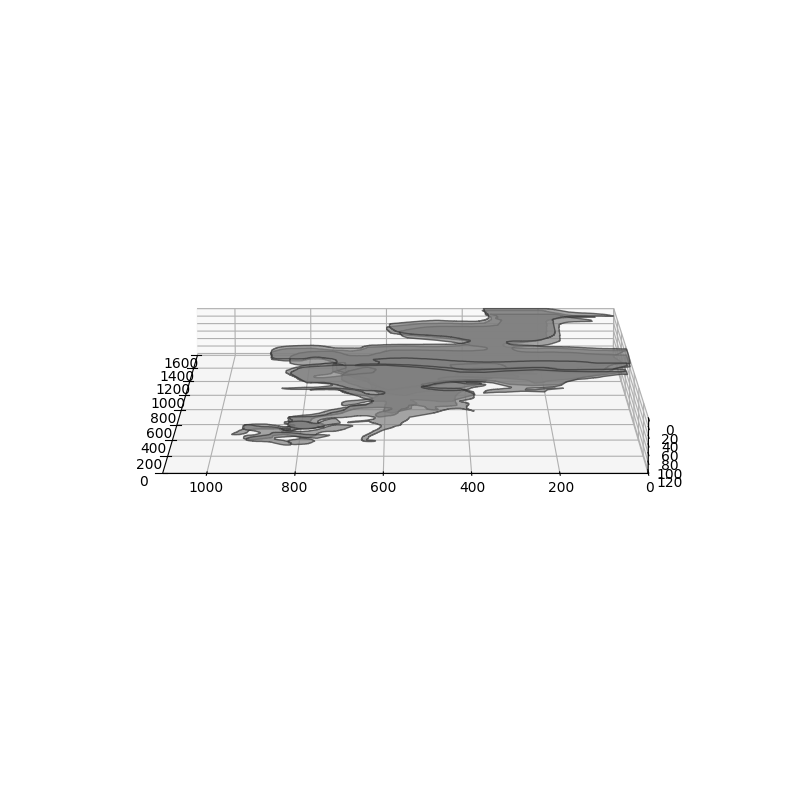

In [507]:
ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')

coords = [np.asarray(x['coordinates'])[:, [1, 0]] for x in regions]

zs = [x['position'] for x in regions]
facecolors = [(.5, .5, .5, 1.) for i in range(len(zs))]
poly = PolyCollection(coords, facecolors=facecolors, alpha=.7, edgecolor=(.2, .2, .2, 1.))

ax.set(xlim=(0, C2 - C1), ylim=(0, R2 - R1), zlim=(0, max(zs)), aspect='equal')
ax.add_collection3d(poly, zs=zs, zdir='z')
ax.view_init(elev=elev, azim=case_to_zeniths[case][roi])
ax.invert_zaxis()
ax.set_aspect('equal')
plt.show()

#### user defined path

In [508]:
# keep = re.split(r'\nObject ID\t', """
# Object ID	28e4e782-02a6-42f5-8b12-5545c85edbc5
# Object ID	9b273882-70cd-4f31-b2a3-4fcb89a3d861
# Object ID	9ade75e2-df25-43b5-ad83-8b4bf6575ecd
# Object ID	57772e61-6c1d-40f1-921d-c79edb578378
# Object ID	3331f2c7-2ed4-45e8-a9a2-ff1c9ec02a4a
# Object ID	23e634ac-1dd0-46b8-aca1-99ea86d39753
# Object ID	c904b121-cc85-4e00-b350-5e6f21f8b64a
# Object ID	e449ad11-2d42-45a8-9264-d395e89191b2
# Object ID	b909d252-1bfe-421d-9183-a2a93cafd163
# Object ID	778fd5c6-456d-45dc-ac09-f72565cd6129""")[1:]
# keep

In [509]:
# # keep.reverse()
# # keep
# x = ['406ac3bf-8609-4786-a1df-6540b4970cea',
#             '8cc2c7fe-be42-401d-b779-18b77ac156a3',
#             '12c03edc-81d2-432f-9809-34efbed321d3',
#             '13b32752-7032-4403-a855-75b2a2320799',
#             '7ecb5ca3-161b-41da-bc89-1b64312c5840',
#             'e86f2c46-6822-4fb0-b8fb-ee0adda87027',
#             '5769757d-7e89-49a6-97e1-8a8419989506',
#             'b5c5ff29-07e4-4ad1-a866-0e3bb78f4283',
#             'c4380e8c-f7ad-4cfc-a4f3-ed430ec2c1bc',
#             '227dad79-9f9d-465b-8543-0605892b42b3',
#             '34b75982-a611-4e25-a583-bf10aafdd5bc',
#             'dc5f3e39-0bea-41d3-b152-8d91c0e1ca17',
#             '60111347-4dcd-465d-8537-82cb1cc5484e',
#             'db3c0014-4c41-49db-9d74-e88f28041aee',
#             'a29d8f43-06d4-4e0f-a059-8a4b9fbf959f',
#             'f47c43ed-3e83-4a2f-86d6-aed44f1316c4',
#             '715e36a2-3832-41a6-8cf3-5a28caf458e8',
#             'acaef067-ff89-4676-b10c-6b5f4fd6560e',
#             'cdef0207-f9b5-4a6b-bdf5-bde6df9f9282',
#             'acaef067-ff89-4676-b10c-6b5f4fd6560e',
#             'fc0a0ccf-7386-416f-b163-99041f2d8918',
#             'f8919fee-046b-436a-b728-94c76c3a153b',
#             '686d4c90-0af6-467a-9134-39f483b04c28',
#             '0070e7b1-9e6b-4cda-af13-b5d6238e97ed',
#             'cbf8e855-8a31-4990-b144-064f544d3066',
#             'e5d1214b-8f62-403c-833a-53032515931c',
#             '24000119-0a82-45c1-8505-dc90901e014f',
#             'cb76f6eb-6278-452d-bb4d-9726d650aec9',
#             'f5c166e7-d9db-4bad-b55f-73a0f0799d60',
#             '2a3facce-de6a-43a7-926b-8fbe42ed75b0',
#             '69f28c38-daa2-4007-85ff-e5a1cf88e3eb',
#             'd32db0ea-a851-4d93-b1bf-430e937a1235',
#             '2feaaa28-3e77-4138-b9a4-0b75f68d2f64',
#             'bcbe6b32-baba-4f9e-bf87-45e5f0660327',
#             'd715e31a-7607-4ac3-b0c2-9456b9244140',
#             '99087c7b-e996-40ed-b0f4-4286822192fa',
#             'b6d1644d-743d-4cf4-9fa0-a43d95ea6baa',
#             'bf6c40d9-bdf2-49a5-a3fe-b6e68d0b77c0',
#             '386d888c-4246-46f5-b7a0-d0a763511097',
#             '90116201-5a8a-4f73-be12-495d21dcf084',
#             '142c7012-69e4-4f2a-b00b-9d350db99fd6',
#             '68f55189-0e6f-41b1-9c65-2823226b8d7e',
#             '511a2ee0-a928-47a5-a586-fab0fb648b99',
#             'f1034984-615e-45a5-a4af-05f2fc4eb1b4',
#             '92b53248-6da0-492a-9c0b-0c2a60946a0d',
#             'b536042f-2705-4627-be52-2465ff038195',
#             '6d7255ad-dc1a-47c4-b99f-6fc5fc3f0772',
# #             '995bd781-223b-4849-a502-640895bcf6d7', has experimental artifact at roi location
#             '9ddde78f-2e7b-4259-9bf9-efdd0a005b79',
#             '79e3353f-c2fe-4d54-8d30-a8a661cf61a1',
#             '2db3f2d8-37ce-4ffa-81ea-7948b9af77ae',
#             'c5facae8-79de-4842-b005-ad9e9d23747e']
# x.reverse()
# x

In [510]:
case_to_keep = {
    'HT704B1': {
        'roi1': [
            'b28d28d2-098a-41aa-8a99-24f8c8753897',
            'efac94bc-f48c-410e-a57d-3cfccc9f95f5',
            'e1967bc8-a7b8-4c08-94f1-20963ffb9e7d',
            'bdb3ea48-34e3-43e8-b8b6-042ab38be524',
            '25f59172-9dc6-4340-a21f-2a2b557176cf',
            '4ea3de46-c2ce-477d-a329-e30488ea405a',
            '20e99f45-3070-4653-8b26-9f9ea56631cb',
            '5f27e9f9-b7cd-4baa-a8a7-134777c849e3',
            'b900774e-7d72-4393-b87c-368c0e6196c9',
#             'f94eb1df-7ba2-40db-8bc2-00ccff0c9bf1', # bad quality xenium
            '3190089c-4751-45f2-8860-40fadce6efdf',
            'd2fff7b6-cee3-404e-abc3-e1b7d7e0a6c6',
            'c6b2d74c-93d1-47d9-90f4-fd6e7d1c18a0',
            '575ddaa1-d483-4c8f-a873-fd20c6322400',
            '0831e146-2e3e-45e3-98ed-3848c95e2694',
            '3dcff188-4448-4511-9576-f5d6397b5c5f',
            '8f7fd7f0-ca13-43d5-a8a5-bc46e8f9b687',
            '817b1cde-8242-47cc-bc35-c905ed2509a4',
            '4e8aaa54-1f8d-4c5c-9447-ff3ee99b1e05',
            '606319be-6df3-4fb7-85f4-0c62f2738122',
            '5121309d-39c8-49a3-b654-5107a10ff03e',
            'e741aea8-1b68-4e57-a1f1-0b922bdb0c35',
            'a4719551-76dd-4117-a82a-c086568f52f2',
            'd2851db4-5e2d-455a-a427-116d37309159',
            '25defdcc-c8c1-4511-9ace-d9dbf639f2b6',
            'a8828943-5520-4944-a509-4138d186b364',
            '90fa10dc-bf88-4ddc-b61b-2a9ac96efa9d',
            '944f7780-d678-49ec-8bd3-82a2d66d139b',
            '7ee62508-a502-404f-b93c-47d0fa181aab',
            '65e2995d-ee34-4db9-9c15-089ff4cb9a98',
            'c9a69fca-8cb9-49d5-8e6a-994a48970c3d',
            'ba166553-c235-4975-add0-1c23f41c356c',
            'd47f5943-f0ca-4244-b509-ecaf6e1c118f',
            'add69252-85f8-4f3e-b8ae-896d0e253891',
            '547b86b0-71a2-477a-a490-43d30da4e237'
        ],
        'roi2': [
            'c2df8514-9463-481a-9b68-c81dd634bb9a',
            '90562e73-1e6b-4137-9993-08a7ce2fbae7',
            '95a69bda-c19c-4245-ad98-3d7fe3c42040',
            '86a1ef36-f5b8-49a5-947c-712086be4462',
            '20f14b1b-4032-46fe-a144-aef4e4d275e3',
            '18ca3507-f9aa-4b71-a85e-acc3086fd4ef',
            '54dac54a-982e-4f59-b140-68e74a1d8a37',
            'c20bd90b-9c63-4e32-ac29-b9433b829bce',
            '7b3c20d2-6713-4768-b5cb-c8be3b10beb3',
            '0e25d6d6-ce97-4ccc-a5bf-14de02812aca',
            'd0b4424c-7884-4326-ba44-6922f879b03a',
            'a41a8966-eb30-4e6d-a156-022aa835ec19',
            '2369a573-9f4e-4728-b6f3-d371a362a430',
            'f2b0563a-8f24-4bc8-8cf2-a13b22337303',
            'e01cf432-8d04-4def-8ce3-cf2ba1af2922',
            '244c386c-93ac-4a5f-bf52-43dcce7a1388',
            '64a35b14-07ff-4c3b-9e91-36b7ef068929',
            'd5b3c3e0-1587-4035-a170-a6cad89409b0',
            'e1da80e0-522a-4a17-a1c1-40e607519d9b',
            '32822652-ce81-4c73-8dde-eeae8b9281d1',
            '7825ad91-6cdf-438f-9c23-5355b493abe1',
            '2590d0c4-2c49-4784-88bd-5dfed44f5f8d',
            'c5054881-2aae-41d8-8490-f5aaeaa4595c',
            '663ebb62-c6c8-4e76-9e6f-731c6285a61f',
            '6b8e5fa7-f29d-4f9b-adaa-80f65ebf6ea9',
            'f230f869-5d5b-4c32-bb99-37430b0e10ea',
            '42e24741-6683-4ddf-ab89-5cf26c56bf78',
            '1c6f258e-dd72-45ac-9874-71565653f6f8',
            'be4a61b7-8871-473d-9f74-f796cd4ef770',
            '7aece61f-8a2b-4fba-99ce-2672dbc9d8b6'
        ],
        'roi3': [
            'd9293330-df8b-43f9-8b88-2375643b60aa',
            '5cb05ed3-2b22-4fd7-bedf-dc8a789df2c0',
            '7a787adf-8fba-403e-9f14-6e1031dcc49a',
            '15f75816-6cc4-4003-a1dd-1cb39ba6d792',
            'f3f5a129-0688-4a27-8b9f-417d87319d31',
            'feb5fb14-b1db-4fa6-b190-74d5c2e9b509',
            'a991b564-c33e-4556-b5d7-06ecb611ef4f',
            'e3f4c83f-8e8d-481b-9749-fad97ad55673',
            '71dff1df-d5bb-40c3-a241-659e82e8a43e',
            '8df68aa8-18a4-47a0-9d8b-796d590eadf9',
            'cb24a200-ca1b-4f9c-bec1-04485e7f2a17',
            '9c138875-2b24-4fb4-a836-9c31a86aaa1a',
            '1cf88277-3817-401b-96f9-ff436c17b4e3',
            'b5b50caf-310a-46a9-8625-0117a4cc23ef',
            'd19aa3c9-50d7-472f-b89d-4b0020f6e2c9',
            '087dda61-66fa-411c-a0a5-9527a7e91bb7',
            '88d99522-c143-4f13-966a-bfb325d36211',
            '175d7942-999a-4970-81f6-b8628d77bf14',
            '00e77665-e65f-43b8-9384-64e0bc8c2efa',
            'ec2baaa5-3c15-48f3-8fdb-d59297f5b1d8',
            'a09d553a-cfd4-4208-8032-d43ea9e75372',
            '55161b6a-6570-4654-ab41-4bb649de3486',
            '57658292-92f8-4ccf-9969-84a32f2ec67f',
            '04ede5e9-423a-4413-a576-9ae2982b4941',
            'da771024-21fd-4e08-8bcb-c0c5fa93419d',
            '6ca9ac30-ee2f-4cbe-86ae-5c5bc30db26e',
            'fed4c60e-a0ca-44c0-a4df-1034a44bb28d',
            '4b01c81d-bc2a-4bda-a5d5-d4afd2889ca0',
            '74d2a21d-0e96-4800-a45a-612dd0946146',
            'f2192037-e309-4050-8463-7a7dd863b0e9',
            '514ccfb4-cdbf-4838-96e8-65721c37b573',
            '58416d17-e99c-4995-9247-2cc86194447c',
            '6cfce6d9-5610-4781-949b-1ca5cad57087',
            'd48bb6ba-60e5-48f4-996c-3c0faaef59e8',
            'c492ce64-340e-412a-a14c-d0928649c892',
            '45837c17-2eb5-4085-a667-04093a4037c9',
            'ef1e621d-8d02-465d-bb4a-5f0e9e3063dd',
            'd4f4ff7b-8ab0-4102-9d3d-fc0f0b620fb4',
            '1d94f5df-e4f5-4a46-b760-1dc1d900a81f',
            '692ee84b-fd2d-4021-bdb2-f8a6ea56b3d8',
            '0ae524c6-9584-41b6-aad3-df7a22061e62',
            '5e3df84c-db8f-43da-b544-fda0c46b819c',
            'c8d3e787-5ebf-443f-82b9-eb3beb3dfa79',
            '8c1f24c9-bf6d-44b3-a957-b957dfe56daf',
            '605d019e-9f72-4560-adc0-44545b9e3049',
            'a87a8ff6-6798-41d0-a0b7-ba13345156b6',
            '25975f0b-55ff-42d1-9864-aec5dfe6b464',
            '54bc8c79-1899-4d00-bad4-83fbd1eacffc',
            'd4024e73-63aa-4439-9111-e70638d3949e',
            '5f7bf971-483e-4f23-a7ec-059d86608264',
            '5f2cebc8-1184-41db-9457-84cb12398be5',
            '815124d6-f3f8-42bc-b674-03c35e21e316',
            '554a534b-ce86-4964-a08f-2cd1ae267808',
            '4bb755cf-557d-452b-89c6-516b698af25a',
            '204e48a8-dec1-42f3-a818-35c024f60497',
            'c37f3f22-7770-4704-a86c-63df31be539b',
            '19d2b0e5-36e4-4b07-825f-c7c408a7d132',
            'c7c9fa45-b71f-4dd5-b4ea-a78838de5531',
            'e7c3f450-80cc-4a43-a7e4-a58cf866db51',
            'faabab0f-8c6a-4849-a630-8641dd59a0c1',
            'da0ccd78-1087-499f-8c57-c4ab4c4824cb',
            'e5e34dd7-c045-4707-acd7-1d3ae547d294',
            'ab36522a-2c36-4ac5-9da3-7cd06c864ea5',
            '90cbcbea-d000-4ea6-a3d5-6b8120a2e66b',
            'e3745bbb-7bc2-46bd-bbe4-961d746938b4',
            'd5b14c04-5529-4dc4-8876-44d2df23c99a',
            'ae3cd8e0-5d43-4eee-9da5-56c29c3a019c',
            '84f6f573-1040-4085-8658-f7f9f6ee1f3e',
            '57ecfcff-43d8-424d-90ab-f01f494dfc07',
            'd02a6b8a-b7b9-46b9-9d8d-5aa78e524eb1',
            '1973bb71-877a-4148-8b7f-f8aea56b1cb3',
            'd2fd5bc4-d27e-484f-8f7f-144d9c4c8a80',
            'e12c90f1-f043-4791-898c-2d66a2093bfc',
            'd6ef14d7-5033-48c7-9781-007c2a3c99a2',
            'fa248064-509e-40ea-872c-74405ca242e3',
            '316ff201-b03f-43fb-97a5-12f760d42cac',
            '3e919934-9f0a-454e-a7bb-48b463c9edca',
            '5fd9d674-a08b-4169-a99b-02fc75e03530',
            'e22ec42a-7b22-4f7a-8251-a9d9817234db',
            'a486cb7e-e508-41c0-8dbb-142a49458ae1',
            'ec9e9e1f-d546-4e79-9985-8a9de833946f',
            '40909d6d-4f49-4c1b-ba1d-4f47bef46ec0',
            'acb0503f-4a7b-46c2-b261-0eb852d1bd8d',
            '09c0405e-8aee-4500-aa1f-4d3cf95629a0',
            '7cc52069-18d5-4331-9f48-3ca7ff008e86',
            '3017e782-2594-4894-bea2-fe394307429a',
            'a1dc0f9b-9074-472c-ae87-4d84e7c02a23',
            '1f86a736-b15d-4c0d-9459-5fc3ef05b0bc',
            '02193002-b5c6-4c79-9cc1-c8b01ac0a6ba',
            '6617a8e2-b5f2-46e8-b067-714fab0f62a2',
            '7ebbea05-4f2c-40fd-af67-b519caecdf1a',
            '3ee51c9b-17a6-4dba-8927-26687c68c6fe',
            '60afa4db-7974-4ef1-a8b2-9650396387fa',
            'd2566c54-4df7-4fa3-acf6-0eba836d929c',
            'e0f3889e-106e-46fb-b2d4-fdb12c2f8b28',
            '2769f76d-7eb7-423e-b85d-48d97e1cc0e2',
            'f53e65bf-4b3e-4b56-8711-02c55f3543c5',
            'b7aae5bb-7562-4b8f-9642-a7c31087e7b2',
            '611017b8-0281-4275-8d73-50799ed26051',
            '87657d2f-ade8-4b22-b3d8-c2647b5d79cf',
            'c9ea219e-6176-439b-8086-33e43f6f2f4c',
            '8520cb16-fadc-46d0-98b0-b76c7328b9dd',
        ]
    },
    'HT891Z1': {
        'roi1': [
            '18073a83-5d22-4c2a-8cc8-e1b27a4de88e',
            'b82e48b8-4f89-4ced-a461-b2a10f0c866c',
            'f512d2b5-cf8d-41bf-bca5-15674ad4aa37',
            '3cefd941-fc48-42c6-b471-69f88f9ed51c',
            'f351469b-1003-4cd7-826e-833225c3fc24',
            'a1cf979d-883d-4ada-868a-547f841429af',
            'b26ee826-3df3-42d6-bb3e-e4421caaab2b',
            '2b560c1a-7146-440d-abfb-96c155fc04ce',
            'f559c8a3-23d8-4028-b91b-07e21689a90b',
            '1ba12732-a5be-4f46-b8a7-1c59bfc5a0bf',
            '72403e0b-b43e-43ec-a552-1a47ab560ac8',
            '5de7cf3d-4b40-4551-8b6c-ce020e51454f',
            'a50f0eed-34a0-4246-b932-1235c35a058d',
            '9447582b-bc67-49ac-a6ab-ec5e838e4fe7',
            'ccac5996-f1d6-4cd9-8244-3a7cce93cd0c',
            '147db08a-a004-4140-8801-abc741f1fa57',
            '5377ed97-9c04-4e68-8fdf-7cd14ce9f6dd',
            'f87c3955-6c2b-4a06-8523-375226ff177c',
            '9b9ae36c-9a19-49c4-bfeb-3d2dee30a730',
            '469fcda1-e3c5-4599-839d-936f706de017',
            'bd096426-679b-4216-a698-7d35a88fe3f0',
            '05838a3f-53ce-426d-8528-bfcb7156c040',
            '76a4896c-958c-4579-886f-2304f6d23086',
            '36b672d2-3e8b-49f6-ae39-92a62ecd712f',
            '78613f98-bda4-4902-a0aa-11f907ac25e2',
            'b67f677a-977d-402a-9b3f-963cbbacb088',
            'f478fe10-a739-49b6-a66b-e78a89114bb8',
            'eeadda0c-15cc-437b-93db-97dc0295c4e7',
            '1eaf2c83-bb10-495a-8780-e148c61f0de6',
            'b9a2b34e-022a-4d2a-a992-07c1850819e6',
            'eee0cc98-b064-4bc7-b46a-4117707a70a8',
            '3ab6068e-2417-4818-81e2-314897e6d8dc',
            '6f627bb9-58ce-474c-a7e9-6cadee6fe97e',
            '1c40e765-cf94-4bd9-8a4a-2392c1b9f4e5',
            'a448a98e-27f7-4d49-80f8-fc43801f79cf',
            'ef0a6544-d5f0-420e-9fef-2d8bf1049dfe',
            '348dadbe-4055-4487-ae91-e0e5afd584fe',
            '83353ce1-70f1-4d5a-ad0c-3d0b2dfeda72',
            '49bf097d-169c-40ab-9d1d-1b5a81124230',
            '1e37985d-d7fa-40d2-b732-1705c8add006',
            '5360344d-4cc6-495c-88c8-920d753afa68',
            '4e2db84b-be15-422b-ab0e-dd03a2dd5b5b',
            '92eb0141-b157-4469-8957-8e87221c4f2e',
            '00ba5441-f476-41d5-acd2-e8eb4652c384',
            '40daecf1-a83e-4cc5-85e5-20908a70a4a2',
            'f6032595-1fd0-44c2-82b0-72a3fac80f03'
        ],
        'roi2': [
            '42c61ec8-46dc-4e05-b951-77b036140cdd',
            '4fd912e9-9eda-4290-aab8-8cfb9bfedb43',
            '2ae1e825-b9cd-45c4-bcf1-b227b48404b1',
            'ae931882-fc2a-4bcb-bb02-d965c6e07256',
            'c2b325db-8518-43fa-8653-b6e0de96a436',
            '92d21f1d-968b-4205-bc6f-8791f5fb7942',
            'bc3ec071-235a-47da-a192-49736ece4a1b',
            'cbd83e7a-d4ec-4558-9145-ecbe3494ee0d',
            '89b146dd-2261-4362-ae61-d812b5a2fb8b',
            'a098aa66-da0a-46ef-8659-ae8fdb02b6c9',
            'f55e7184-f872-4f3c-a01c-6072351148d9',
            '98986d9e-1677-4bca-974f-570e96c7d7f0',
            '12c3eac2-8606-41be-892e-689133c3ad80',
            '71817de5-241d-4448-9aad-91df6ded89c1',
            '9e8d366d-95a4-4a9b-a9da-07b5acf951e2',
            '1d408116-9652-4a57-bab8-e3d48ff01de2',
            '3f382232-fad5-4246-8029-b2ff0fca459d',
            '4dcbec5f-25c4-441e-b603-0c0b45b74c43',
            'ad46ac66-0e8b-48f1-aba8-e300d19278d2',
            '32ce1bff-0284-4514-ba98-04506f20f256',
            '24687041-03b2-4e55-a05b-0b069a3403e5',
            '38ba9ae1-de88-4b38-a29e-cb9cc87acc41',
            '7a3535f1-c30c-40c1-9d31-24c2ee7e58f9',
            '0070e7b1-9e6b-4cda-af13-b5d6238e97ed',
            'cbf8e855-8a31-4990-b144-064f544d3066',
            'e5d1214b-8f62-403c-833a-53032515931c',
            '24000119-0a82-45c1-8505-dc90901e014f',
            'cb76f6eb-6278-452d-bb4d-9726d650aec9',
            'f5c166e7-d9db-4bad-b55f-73a0f0799d60',
            '2a3facce-de6a-43a7-926b-8fbe42ed75b0',
            '69f28c38-daa2-4007-85ff-e5a1cf88e3eb',
            '0b7ef988-877b-4f6e-9b3f-3b7b33154774',
            '2feaaa28-3e77-4138-b9a4-0b75f68d2f64',
            'bcbe6b32-baba-4f9e-bf87-45e5f0660327',
            'd715e31a-7607-4ac3-b0c2-9456b9244140',
            '99087c7b-e996-40ed-b0f4-4286822192fa',
            'b6d1644d-743d-4cf4-9fa0-a43d95ea6baa',
            'bf6c40d9-bdf2-49a5-a3fe-b6e68d0b77c0',
            '386d888c-4246-46f5-b7a0-d0a763511097',
            '90116201-5a8a-4f73-be12-495d21dcf084',
            '142c7012-69e4-4f2a-b00b-9d350db99fd6',
            '68f55189-0e6f-41b1-9c65-2823226b8d7e',
            '511a2ee0-a928-47a5-a586-fab0fb648b99',
            'c3f12f7e-3df7-43fc-b275-503a6a37765c',
            'f1034984-615e-45a5-a4af-05f2fc4eb1b4',
            '92b53248-6da0-492a-9c0b-0c2a60946a0d',
            '2ef103e8-c8f1-4380-96f7-45f77427c077',
            'b536042f-2705-4627-be52-2465ff038195',
            '6d7255ad-dc1a-47c4-b99f-6fc5fc3f0772',
#             '995bd781-223b-4849-a502-640895bcf6d7', has experimental artifact at roi location
            '9ddde78f-2e7b-4259-9bf9-efdd0a005b79',
            '79e3353f-c2fe-4d54-8d30-a8a661cf61a1',
            '2db3f2d8-37ce-4ffa-81ea-7948b9af77ae',
            'c5facae8-79de-4842-b005-ad9e9d23747e'
        ],
        'roi2-p2': [
            '406ac3bf-8609-4786-a1df-6540b4970cea',
            '8cc2c7fe-be42-401d-b779-18b77ac156a3',
            '12c03edc-81d2-432f-9809-34efbed321d3',
            '13b32752-7032-4403-a855-75b2a2320799',
            '7ecb5ca3-161b-41da-bc89-1b64312c5840',
            '1198800c-9db2-4887-93c2-7f121df0468e',
            '5769757d-7e89-49a6-97e1-8a8419989506',
            'b5c5ff29-07e4-4ad1-a866-0e3bb78f4283',
            'c4380e8c-f7ad-4cfc-a4f3-ed430ec2c1bc',
            '227dad79-9f9d-465b-8543-0605892b42b3',
            '34b75982-a611-4e25-a583-bf10aafdd5bc',
            'dc5f3e39-0bea-41d3-b152-8d91c0e1ca17',
            '60111347-4dcd-465d-8537-82cb1cc5484e',
            'db3c0014-4c41-49db-9d74-e88f28041aee',
            'a29d8f43-06d4-4e0f-a059-8a4b9fbf959f',
            'f47c43ed-3e83-4a2f-86d6-aed44f1316c4',
            '46440f35-16e2-4395-9394-d5320861bf78',
            'acaef067-ff89-4676-b10c-6b5f4fd6560e',
            'cdef0207-f9b5-4a6b-bdf5-bde6df9f9282',
            'acaef067-ff89-4676-b10c-6b5f4fd6560e',
            '62b6d19e-4d3b-46f5-b0dd-51028b4246b7',
            'f8919fee-046b-436a-b728-94c76c3a153b',
            '686d4c90-0af6-467a-9134-39f483b04c28',
            '0070e7b1-9e6b-4cda-af13-b5d6238e97ed',
            'cbf8e855-8a31-4990-b144-064f544d3066',
            'e5d1214b-8f62-403c-833a-53032515931c',
            '24000119-0a82-45c1-8505-dc90901e014f',
            'cb76f6eb-6278-452d-bb4d-9726d650aec9',
            'f5c166e7-d9db-4bad-b55f-73a0f0799d60',
            '2a3facce-de6a-43a7-926b-8fbe42ed75b0',
            '69f28c38-daa2-4007-85ff-e5a1cf88e3eb',
            '0b7ef988-877b-4f6e-9b3f-3b7b33154774',
            '2feaaa28-3e77-4138-b9a4-0b75f68d2f64',
            'bcbe6b32-baba-4f9e-bf87-45e5f0660327',
            'd715e31a-7607-4ac3-b0c2-9456b9244140',
            '99087c7b-e996-40ed-b0f4-4286822192fa',
            'b6d1644d-743d-4cf4-9fa0-a43d95ea6baa',
            'bf6c40d9-bdf2-49a5-a3fe-b6e68d0b77c0',
            '386d888c-4246-46f5-b7a0-d0a763511097',
            '90116201-5a8a-4f73-be12-495d21dcf084',
            '142c7012-69e4-4f2a-b00b-9d350db99fd6',
            '68f55189-0e6f-41b1-9c65-2823226b8d7e',
            '511a2ee0-a928-47a5-a586-fab0fb648b99',
            'c3f12f7e-3df7-43fc-b275-503a6a37765c',
            'f1034984-615e-45a5-a4af-05f2fc4eb1b4',
            '92b53248-6da0-492a-9c0b-0c2a60946a0d',
            '2ef103e8-c8f1-4380-96f7-45f77427c077',
            'b536042f-2705-4627-be52-2465ff038195',
            '6d7255ad-dc1a-47c4-b99f-6fc5fc3f0772',
#             '995bd781-223b-4849-a502-640895bcf6d7', has experimental artifact at roi location
            '9ddde78f-2e7b-4259-9bf9-efdd0a005b79',
            '79e3353f-c2fe-4d54-8d30-a8a661cf61a1',
            '2db3f2d8-37ce-4ffa-81ea-7948b9af77ae',
            'c5facae8-79de-4842-b005-ad9e9d23747e'
        ],
    },
    'HT913Z1': {
        'roi1': [
            'f3ae0453-4fd5-4160-8152-c3e4853df1f6',
            '6b0118a5-dc52-4a1f-b5a5-2473737c51d8',
            '21739bd1-4680-41e6-bcfa-579acd5cef7e',
            '8faa453a-863d-4c47-b0c8-aa155019b617',
            '068cc652-cecc-4ddb-916c-0217d1951726',
            '2d6868cb-a992-432e-8aa6-687aa066d6f8',
            '98879cc8-39de-44a1-bd17-239a738a3681',
            'f97a7e10-7318-4a0e-a719-ee4a01d7ee4f',
            '2c1d6aa2-96f3-492b-93c0-4f31dd62b193',
            '123856d6-8930-4c12-8019-9123044f2c62',
            '2b24ad50-8653-48c7-ae47-196fa866069c',
            'd311653a-c074-44ea-9ac4-eaa2bd02ce33',
            '698509ad-8b1b-439f-9554-1052e7dac7df',
            '2d07e61d-fede-4725-ba01-5491f645cb56',
            'd5dcdf94-6298-4810-822e-ba3de7aaa5b7',
            'ff3565a9-c5c7-434d-9f15-d6d018433cbd',
            '0d292d7a-ffc1-4fd0-8f35-4ff06249ba0a',
            '1272a712-f636-44cd-a270-ce6765f33b64',
            '8a4047a0-62f8-4554-9b88-7ae82255aa84',
            '294bfeed-ca22-4461-8f5c-656d3a0ab7fc',
            '734069e4-66e4-4a0c-93ee-115a1cb6e4c0',
            '611c1c4c-4c78-407f-9592-994e87ee0ca0',
            '08e558a9-a333-498d-8946-e738113ac6a0',
            '5a0b7ef9-e000-4007-b4f7-ccec17ed2ca1',
            '16d7d20e-f105-48b4-a249-a6a34fc4dac4',
            '88cb54d9-34ee-43bb-a7e3-bca72150255a',
            '63fe76b2-1933-48ed-a0aa-683824d54313',
            'e7b2f8f9-f594-4960-be84-2bbcff202b7f',
            '41f88b54-af11-4822-b510-9a39c1ecb1da',
            '9f01e438-811b-4237-8012-816cb5e8a36a',
            'cfd5c4cd-0ade-4337-be45-59198d41ead0',
            '2b5a42d5-653c-406d-93ad-8f1891329c78',
            'b3b23bc8-dbb7-4f1c-86d8-b4af0925c065',
            '69485c45-0726-4c09-acdf-6b58d8a0fda6',
            'e9bb28b8-626c-4fbd-b345-d17a867ae103',
            '69e82234-1d53-48e4-ab5e-d42deb6b2af5',
            '32de237e-c797-4efc-87bd-1103157612fa',
            '1215ccaf-0c17-4f34-a945-4fafeb196884',
            'cfbd64e0-2c10-41ce-8e06-1cc8fe4b4664',
            'ba028480-9dfe-462c-87ac-0dbce825ca91',
            '3f4e1d40-ba5a-495c-8d53-52b9cb20571a',
            'a25ad214-e8f2-4950-bdbf-c552929a1287',
            'a1c63d7a-d930-4836-b680-55014c4d272c',
            '10b0800f-9d79-4cdc-b32b-544fcc3afed9',
            'e96f6b1c-102b-4ddc-aada-d021b0095771',
            '999aeb4b-b637-4dcc-84ab-848eaf8d5191',
            '13ffff87-3c4c-43c3-a6c0-1383cce2f324',
            '24e8def7-69de-43f8-9a5b-fb7631f641a3',
            '5ea70ce2-e418-483d-89f6-eea5e0d721aa',
            '6d6519b0-a5cc-4a41-b123-69bcc04fb956',
            '6770647f-86b0-4764-ba34-4de8083fbccd',
            '46945474-3656-45e4-9454-6f8f37d5239e',
            '1acbeb2a-9f27-4db4-8a43-37bdda7e15a4',
            'f180f7b9-f91d-4e7d-a5c9-07cdb11f7724',
            '11b9fd02-8410-441c-945b-226ae5af24fa',
            '1c39c5e6-68df-437e-a81c-76b6216472a5',
            'a3cb317d-8184-4fdd-a114-1f0f8e196a5c',
            '747f20ab-a9d9-4cd7-8804-f51791fc7329',
            '62768ec5-e385-416b-b1a0-6127470a4ec9',
            '7c39f50e-4913-44b8-a97e-a858839f1499',
            '1ff275e0-c951-4067-b7f9-cc72f7543230',
            '38decc88-9efb-44ef-9dd2-f3939be3637e',
            '5257ac08-4312-4947-bdaa-312a58dd2632',
            '6ae06888-e0c9-4715-9313-12930c270f2b',
            'f0b857f5-260b-4245-b625-664515bdbdf7',
            '707b6831-fa35-423f-b35c-86fbf4f2b14f',
            'a278652c-7add-4781-9926-959de4f531fd',
            '19b3be03-9e23-477e-a412-b9e36b31dac0',
            '05ba971a-105f-4dd5-b5b9-51fff0886986'
        ],
        'roi1-p2': [
            'f3ae0453-4fd5-4160-8152-c3e4853df1f6',
            '6b0118a5-dc52-4a1f-b5a5-2473737c51d8',
            '21739bd1-4680-41e6-bcfa-579acd5cef7e',
            '8faa453a-863d-4c47-b0c8-aa155019b617',
            '068cc652-cecc-4ddb-916c-0217d1951726',
            '2d6868cb-a992-432e-8aa6-687aa066d6f8',
            '98879cc8-39de-44a1-bd17-239a738a3681',
            'f97a7e10-7318-4a0e-a719-ee4a01d7ee4f',
            '2c1d6aa2-96f3-492b-93c0-4f31dd62b193',
            '123856d6-8930-4c12-8019-9123044f2c62',
            '2b24ad50-8653-48c7-ae47-196fa866069c',
            'd311653a-c074-44ea-9ac4-eaa2bd02ce33',
            '698509ad-8b1b-439f-9554-1052e7dac7df',
            '2d07e61d-fede-4725-ba01-5491f645cb56',
            'd5dcdf94-6298-4810-822e-ba3de7aaa5b7',
            'ff3565a9-c5c7-434d-9f15-d6d018433cbd',
            '0d292d7a-ffc1-4fd0-8f35-4ff06249ba0a',
            '1272a712-f636-44cd-a270-ce6765f33b64',
            '8a4047a0-62f8-4554-9b88-7ae82255aa84',
            '294bfeed-ca22-4461-8f5c-656d3a0ab7fc',
            '734069e4-66e4-4a0c-93ee-115a1cb6e4c0',
            '611c1c4c-4c78-407f-9592-994e87ee0ca0',
            '08e558a9-a333-498d-8946-e738113ac6a0',
            '5a0b7ef9-e000-4007-b4f7-ccec17ed2ca1',
            '16d7d20e-f105-48b4-a249-a6a34fc4dac4',
            '88cb54d9-34ee-43bb-a7e3-bca72150255a',
            '63fe76b2-1933-48ed-a0aa-683824d54313',
            'e7b2f8f9-f594-4960-be84-2bbcff202b7f',
            '41f88b54-af11-4822-b510-9a39c1ecb1da',
            '9f01e438-811b-4237-8012-816cb5e8a36a',
            'cfd5c4cd-0ade-4337-be45-59198d41ead0',
            '2b5a42d5-653c-406d-93ad-8f1891329c78',
            'b3b23bc8-dbb7-4f1c-86d8-b4af0925c065',
            '69485c45-0726-4c09-acdf-6b58d8a0fda6',
            'e9bb28b8-626c-4fbd-b345-d17a867ae103',
            '69e82234-1d53-48e4-ab5e-d42deb6b2af5',
            '32de237e-c797-4efc-87bd-1103157612fa',
            '1215ccaf-0c17-4f34-a945-4fafeb196884',
            'cfbd64e0-2c10-41ce-8e06-1cc8fe4b4664',
            'ba028480-9dfe-462c-87ac-0dbce825ca91',
            '3f4e1d40-ba5a-495c-8d53-52b9cb20571a',
            'a25ad214-e8f2-4950-bdbf-c552929a1287',
            'a1c63d7a-d930-4836-b680-55014c4d272c',
            '10b0800f-9d79-4cdc-b32b-544fcc3afed9',
            'e96f6b1c-102b-4ddc-aada-d021b0095771',
            '999aeb4b-b637-4dcc-84ab-848eaf8d5191',
            '13ffff87-3c4c-43c3-a6c0-1383cce2f324',
            '24e8def7-69de-43f8-9a5b-fb7631f641a3',
            'f0344e12-dfab-435f-ac10-f3617b1a68e4',
            '319a12c6-61fa-44c3-83b1-634a6d6110d2',
            '55e8ca89-2e8b-41f3-bb5d-2a32953c3633',
            '1f778fba-5245-465b-b816-8d961cb2f07e',
            '1dbaa429-b7bc-4d32-a106-7ccf90e1debe',
            '44abf31f-435e-44ed-96fc-6f5cb8199872',
            'c5d46575-8d2b-4adf-9c06-6e7a084f5160',
            'f38ae00d-8cc5-48bc-ad81-ddd0a7c77491',
            'e47e1bc7-59ff-4bbd-b000-3ce4a8277608',
            '417f8171-130d-4d6b-a20d-533469e49394',
            '5018f5a9-cc31-4865-a80b-4ba7346da7e3',
            'def6ab22-ba52-47ab-9cb6-335dc41b9071',
            'dad672b0-b8d9-4c15-b760-5c2cedc4bbcf',
            'def6ab22-ba52-47ab-9cb6-335dc41b9071',
            '6ea8124d-7d97-4d3d-b62c-742978edd727',
            '96e16045-5c19-4de6-9ec4-ff2b5d042c3b',
            '42982e7a-8a75-47b4-a70e-12742cf71d1d',
            'd66c4b32-dfda-4488-a276-9a69b3b06766',
            '61bbd93d-6fbf-4fdf-a68d-247d8b34ba44',
            'd78e5d51-75f5-4a2e-8b3e-c664627b2283',
            'a67e5eea-7f04-4d40-a744-7f1592360ca7',
            'c3761fda-d922-42ae-b03f-6ab57dc26abf',
            '58fb0904-e057-45ed-930b-56d3080e9475',
            'a8b7a1c3-0328-49d3-970d-c1d2c0badb99',
            'cfa37172-2eed-472e-873d-2deefc18eaa8',
            '0ac459e0-0475-419f-9bf3-dec19b27432e',
            '705fd4e0-1653-4ca2-ac8d-652ab8c5d757',
            '691ce62b-2f07-4e9b-8645-94daa4fffe42',
            '0d40da4f-96d8-4c16-8865-5826b89c7cd8',
            'fc398e02-0b4e-4aa5-9ddf-78dc802ac36b',
            '320e7ebf-0d9b-4e8b-a2f2-35f826d22b12',
            '29936485-76b2-4cf0-a192-bb115b0879fc',
            '9f862fee-f496-413b-aaca-1f25743cb3b0',
            '1c23d120-7bb5-48e7-8282-9075fc53d7b2',
            '4180718b-5154-4986-8dd1-b805d1c5259b',
            '8084f233-6908-4eb5-b59c-672ec635dd24',
            'f67e7df9-e3db-4638-aa53-94320d8ebee6',
            'b419dc0f-ebf5-495e-b0fe-adb40e6e7f2d',
            'b87ebee3-83d5-4c0b-a387-ff6b27180c9f',
            '54a86728-f88b-4f39-92e1-fe80b5338f43',
            'fa868129-7357-40ae-bb02-82cfbde62824',
            'da3b9652-d135-4fb6-845d-3e00d0b7affd',
            'fa7276e1-8726-46fe-90e0-1e1fba757ae2',
            '53e9c406-3cac-4717-b7a0-265ee4e92a6d',
            '6c6a120a-20f6-49bb-b1d3-ffdbc20680d3',
            'd08d2c57-ffba-4202-82cd-7c905b9b33fd',
            'ee360b07-1eb0-4865-9aaf-1365a1e6dadf',
            '6ea61fdb-268a-4ccc-b700-3993c40190e0',
            '7280c65b-c882-410e-ac11-3a84516789d8',
            '9c68cb2c-52bc-494f-aed9-1eda41f169bb',
            '08d72019-c478-4334-875b-541201ca9390',
            '74379876-7194-4d55-b2fa-888af7d8b817',
            'bf9df781-dfb4-4dd8-af97-cf5465a0c774',
            '31cbbc10-1c71-49f1-8a1b-4e3df3fd28c9',
            '5c471a18-152f-452e-8fe3-236f84c55eb9',
            '71ff5553-095e-4e00-acdb-8668f9f7c259',
            '171fe4c8-9a3b-4906-b1d7-578d4a817cd1',
            '975d5e6a-4b66-4381-8a64-24d4e33519f3',
            '794ed60a-ac9b-4fa0-91a4-db4a95fa3837',
            '4dbbf490-9e06-4e9d-b3a1-8e51b01d2724',
            '4b367800-05dc-49e6-b4f3-115486708c13',
            '6cc57d22-3851-4679-986c-bb0851bfe260',
            'd6e00926-a925-4911-a8bc-6e89b959e0d1',
            '7137c8cf-712c-420e-a5ae-954054cc3844',
            '5e3b6271-a558-456e-9bdb-159fde6657af',
            'b70fc230-5621-40e6-92b1-ca08b2ad2d5e',
            '2bac6c01-236b-4cc6-8cda-2333d65d4898',
            'd6eaefdf-709a-418e-b22b-a9b1b60b118e',
            '0eb5590d-0359-4c5d-8178-90fd5a971f33'
        ]
    },
    'HT206B1': {
        'roi1': [
            '78ddd8ed-908d-4b95-bdd0-f94cae4064d2',
            'fc53ddf9-c297-4f8d-94df-ed5792082f2c',
            'fdeade90-b9b0-475e-a77b-fbc3ddae591d',
            '65a1eeb5-b03a-49b2-af74-d458a0c84672',
            '849d363a-be02-40af-81ba-72eb112e4d70',
            '0ebe4178-4c0a-42d1-9d03-e2db528398e3',
            'eecdb296-f8c0-49f1-bbef-b9cf9ccb5009',
            '751935f4-514a-47a7-a95a-cf6bc601ebe3',
            'a15f9fc3-9a15-4bbc-a566-a9f62f83a6e2',
            'c87762cd-c714-45a6-91d6-e8321989cb26',
            '6578a319-60aa-422e-97d9-94eb5962913a',
            'b0125c68-f2fb-4d85-a78e-decf4faaaca4',
            '8a1ba4cb-12a3-468e-a66b-aff979c36e18',
            '31b6353d-1add-4326-b062-680c1fcb218e',
            '8a1ba4cb-12a3-468e-a66b-aff979c36e18',
            'b0125c68-f2fb-4d85-a78e-decf4faaaca4',
            '6578a319-60aa-422e-97d9-94eb5962913a',
            '132a3bbb-01de-49f6-a5f6-9abab2724546',
            '5ce4189b-649a-42e9-a6fb-cd9855c4bc1c',
            '474b6695-9355-46c1-9b76-f15372e58fd8',
            '114a7cc7-aedb-429b-84c0-832987b32550',
            'e4901972-fd62-4b3f-b451-67e3036627db',
            'db04a5af-d5d1-4d66-b0b6-99be6a919155',
            '7d95ab39-abc8-4d2e-b098-775383334fa7',
            'f3d1f80e-8a31-4579-b545-ef19081b74de',
            '6a2dc0b2-8b14-475b-9c30-0605f5bfab13',
            '3229dced-e44d-4232-a6af-ae0972c2a081'
        ],
        'roi2': [
            '9b6c4b7c-334e-44c1-913d-ad3a85c19037',
            '36007c49-205d-48ee-9b63-dfcb460e56b1',
            'd3c2ad53-613a-4265-a031-db7285af2e45',
            'c3f440eb-55ef-4585-8272-647929ddfa85',
            '82c355bc-ee50-423d-9bb5-cf5fe192567f',
            '39a9a982-8b02-4a1e-a09f-ddf4a1ab9e06',
            '75331121-aff2-49bb-b158-371ad47d24d6',
            'c18608c1-c6ed-4ea2-8bbc-940d62a109f6',
            '798bdf7c-7ac3-4e7b-96d8-73b440b88b13',
            '02404887-4c4f-4c41-a63f-adc8a8c519a5',
            'a50eff3f-d0a5-409b-92d4-eb3cf07cbadf',
            'dcd20ad5-fe29-467a-8c66-00bf74d31e17',
            'e4932d12-2a7e-4c0d-9c58-b773d8577a30',
            'bbc8d158-839e-4b65-8a8c-36e933732b88',
            '1000fd03-c370-4249-bb1e-15ea5ced685f',
            '9b741c21-1ea5-4b83-abf9-e0b51cba93c1'
        ]
    },
    'HT397B1': {
        'roi1': [
            '28e4e782-02a6-42f5-8b12-5545c85edbc5',
            '9b273882-70cd-4f31-b2a3-4fcb89a3d861',
            '9ade75e2-df25-43b5-ad83-8b4bf6575ecd',
            '57772e61-6c1d-40f1-921d-c79edb578378',
            '3331f2c7-2ed4-45e8-a9a2-ff1c9ec02a4a',
            'b13980e9-baf2-49a2-a226-bb0ba45ccce3',
            'c904b121-cc85-4e00-b350-5e6f21f8b64a',
            'e449ad11-2d42-45a8-9264-d395e89191b2',
            'b909d252-1bfe-421d-9183-a2a93cafd163',
            '778fd5c6-456d-45dc-ac09-f72565cd6129'
        ],
    }
}

In [511]:
# keep.reverse()
# keep

## remaining analyses

In [512]:
keep = case_to_keep[case][roi]

In [513]:
for x in regions:
    print(x['id'], x.get('dtype'), x.get('dtype_ident'), x['sid'])

28e4e782-02a6-42f5-8b12-5545c85edbc5 visium visium_0 HT397B1-U1
9b273882-70cd-4f31-b2a3-4fcb89a3d861 multiplex multiplex_0 HT397B1-U2
9ade75e2-df25-43b5-ad83-8b4bf6575ecd batch2_he batch2_he_0 HT397B1-U4
57772e61-6c1d-40f1-921d-c79edb578378 batch2_he batch2_he_0 HT397B1-U8
3331f2c7-2ed4-45e8-a9a2-ff1c9ec02a4a batch2_he batch2_he_0 HT397B1-U11
c904b121-cc85-4e00-b350-5e6f21f8b64a batch2_he batch2_he_0 HT397B1-U16
e449ad11-2d42-45a8-9264-d395e89191b2 visium visium_0 HT397B1-U21
b909d252-1bfe-421d-9183-a2a93cafd163 multiplex multiplex_1 HT397B1-U22
778fd5c6-456d-45dc-ac09-f72565cd6129 batch2_he batch2_he_0 HT397B1-U20
b13980e9-baf2-49a2-a226-bb0ba45ccce3 multiplex multiplex_0 HT397B1-U12


In [514]:
for x in keep:
    region = region_id_to_region[x]
    if region.get('dtype', '') in ['xenium', 'cosmx', 'vishd', 'visium']:
        print(region['id'], region['position'], region['z'], region['dtype'])

28e4e782-02a6-42f5-8b12-5545c85edbc5 0 0 visium
e449ad11-2d42-45a8-9264-d395e89191b2 100 7 visium


In [515]:
import seaborn as sns
colors = sns.color_palette('deep')
colors

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [516]:
dtype_to_color = {
    'xenium': colors[0],
    'multiplex': colors[2],
    'he': colors[4],
    'batch2_he': colors[4],
    'cosmx': colors[5],
    'vishd': colors[8],
    'visium': colors[3],
}

dtype_to_edgecolor = {
    'xenium': sns.color_palette('dark')[0],
    'multiplex': sns.color_palette('dark')[2],
    'he': sns.color_palette('dark')[4],
    'batch2_he': sns.color_palette('dark')[4],
    'cosmx': sns.color_palette('dark')[5],
    'vishd': sns.color_palette('dark')[8],
    'visium': sns.color_palette('dark')[3],
}

In [517]:
def plot_regions(rs, facecolors=(.5, .5, .5, 1.), edgecolors=(.2, .2, .2, 1.), linewidths=1, alpha=.7, elev=10.):
    ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')

    coords = [np.asarray(x['coordinates'])[:, [1, 0]] for x in rs]
    zs = [x['position'] for x in rs]
    poly = PolyCollection(coords, facecolors=facecolors, alpha=alpha, edgecolor=edgecolors, linewidths=linewidths)

    ax.set(xlim=(0, C2 - C1), ylim=(0, R2 - R1), zlim=(0, max(zs)))
    ax.add_collection3d(poly, zs=zs, zdir='z')
    ax.view_init(elev=elev, azim=case_to_zeniths[case][roi])
    ax.invert_zaxis()
    ax.set_aspect('equal')

    return ax

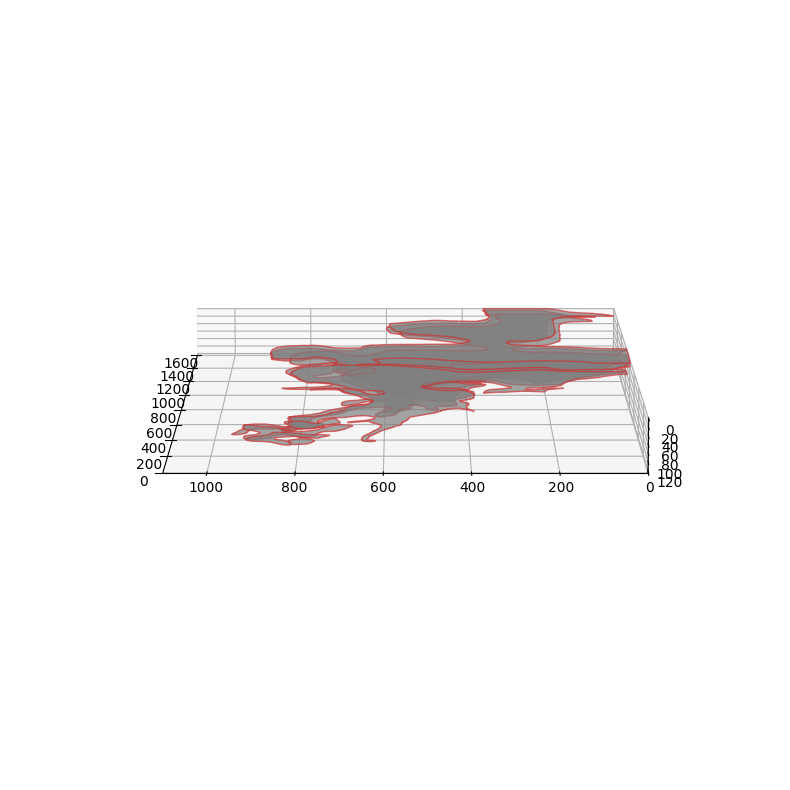

In [518]:
rs = [x for x in regions if x['id'] not in keep]
facecolors = [(.5, .5, .5, 1.)] * len(rs)
edgecolors = [(.2, .2, .2, 1.)] * len(rs)

keep_rs = [x for x in regions if x['id'] in keep]
coords += [x['coordinates'] for x in keep_rs]
zs += [x['position'] for x in keep_rs]
facecolors += [(.5, .5, .5, 1.)] * len(keep_rs)
edgecolors += [(.8, .2, .2, 1.)] * len(keep_rs)

rs += keep_rs

ax = plot_regions(rs, facecolors=facecolors, edgecolors=edgecolors, elev=elev, alpha=.7)
plt.savefig(fig_dir / f'{roi}_3d_section_recon.svg')

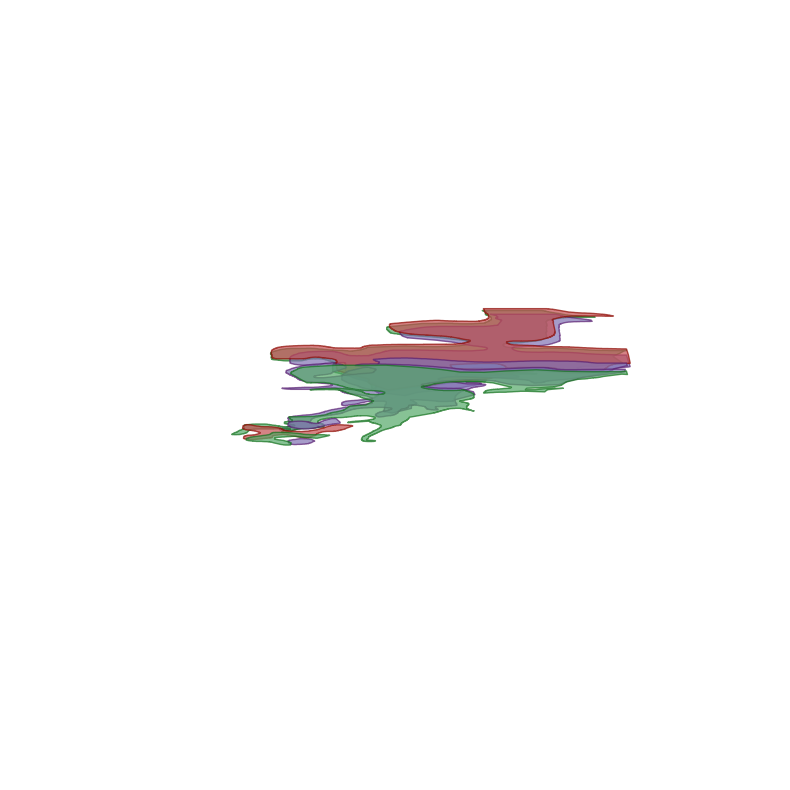

In [519]:
rs = [x for x in regions if x['id'] in keep]
facecolors = [dtype_to_color[x['dtype']] for x in rs]
edgecolors = [dtype_to_edgecolor[x['dtype']] for x in rs]
ax = plot_regions(rs, facecolors=facecolors, edgecolors=edgecolors, alpha=.7, elev=elev)
ax.set_axis_off()

plt.savefig(fig_dir / f'{roi}_3d_section_recon_iso.svg')

###### images for path

In [476]:
case_to_view_details = {
    'HT397B1': {
        'roi1': {
            'radius': 549,
            'thickness': 15,
            'expansion': 40
        },
    },
    'HT206B1': {
        'roi1': {
            'radius': 300,
            'thickness': 10,
            'expansion': 25
        },
        'roi2': {
            'radius': 700,
            'thickness': 20,
            'expansion': 50
        },
    },
    'HT704B1': {
        'roi1': {
            'radius': 250,
            'thickness': 10,
            'expansion': 25
        },
        'roi2': {
            'radius': 200,
            'thickness': 10,
            'expansion': 25
        },
        'roi3': {
            'radius': 600,
            'thickness': 20,
            'expansion': 50
        },
    },
    'HT891Z1': {
        'roi1': {
            'radius': 150,
            'thickness': 8,
            'expansion': 20
        },
        'roi2': {
            'radius': 220,
            'thickness': 10,
            'expansion': 25
        },
        'roi2-p2': {
            'radius': 300,
            'thickness': 10,
            'expansion': 25
        }
    },
    'HT913Z1': {
        'roi1': {
            'radius': 300,
            'thickness': 10,
            'expansion': 25
        },
        'roi1-p2': {
            'radius': 300,
            'thickness': 10,
            'expansion': 25
        }
    },
}

In [243]:
radius = case_to_view_details[case][roi]['radius']
imgs = []
for rid in keep:
    print(rid)
    region = region_id_to_region[rid]
    mask = region['mask']
    
    rlabeled = skimage.morphology.label(mask)
    prop = skimage.measure.regionprops(rlabeled)[0]
    r, c = prop['centroid']
    r, c = int(r), int(c)
    
    r1 = max(0, r - radius)
    c1 = max(0, c - radius)
    r2 = min(mask.shape[0] - 1, r + radius)
    c2 = min(mask.shape[1] - 1, c + radius)
    diam = radius * 2
    if r2 - r1 < diam:
        if r1 == 0:
            r2 += diam - (r2 - r1)
        else:
            print('here')
            r1 -= diam - (r2 - r1)
    if c2 - c1 < diam:
        if c1 == 0:
            c2 += diam - (c2 - c1)
        else:
            c1 -= diam - (c2 - c1)
    rgb = sid_to_rgb[region['sid']].copy()
    rgb = rgb[r1:r2, c1:c2]
    mask = mask[r1:r2, c1:c2]
    
    expanded = mask.copy()
    for i in range(case_to_view_details[case][roi]['expansion']):
        expanded = skimage.morphology.binary_dilation(expanded)
    
    inner = expanded.copy()
    for i in range(case_to_view_details[case][roi]['thickness']):
        inner = skimage.morphology.binary_erosion(inner)
    ring = expanded ^ inner
    rgb[ring] = [255, 255, 0]
    
    
    
    imgs.append(rgb)
len(imgs)

9b6c4b7c-334e-44c1-913d-ad3a85c19037
36007c49-205d-48ee-9b63-dfcb460e56b1
d3c2ad53-613a-4265-a031-db7285af2e45
c3f440eb-55ef-4585-8272-647929ddfa85
82c355bc-ee50-423d-9bb5-cf5fe192567f
here
39a9a982-8b02-4a1e-a09f-ddf4a1ab9e06
here
75331121-aff2-49bb-b158-371ad47d24d6
here
c18608c1-c6ed-4ea2-8bbc-940d62a109f6
here
798bdf7c-7ac3-4e7b-96d8-73b440b88b13
here
02404887-4c4f-4c41-a63f-adc8a8c519a5
here
a50eff3f-d0a5-409b-92d4-eb3cf07cbadf
here
dcd20ad5-fe29-467a-8c66-00bf74d31e17
here
e4932d12-2a7e-4c0d-9c58-b773d8577a30
here
bbc8d158-839e-4b65-8a8c-36e933732b88
here
1000fd03-c370-4249-bb1e-15ea5ced685f
here
9b741c21-1ea5-4b83-abf9-e0b51cba93c1
here


16

9b6c4b7c-334e-44c1-913d-ad3a85c19037


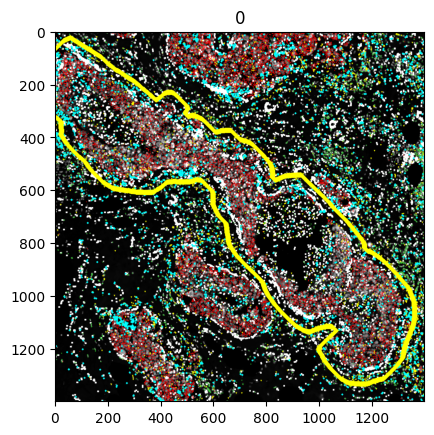

36007c49-205d-48ee-9b63-dfcb460e56b1


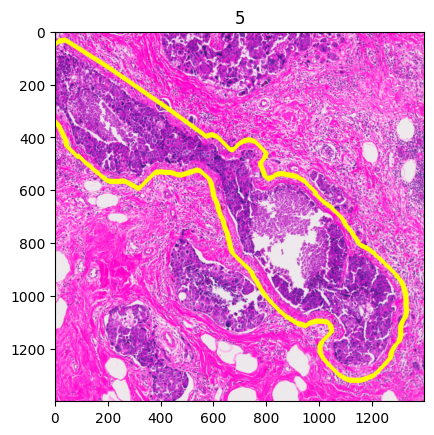

d3c2ad53-613a-4265-a031-db7285af2e45


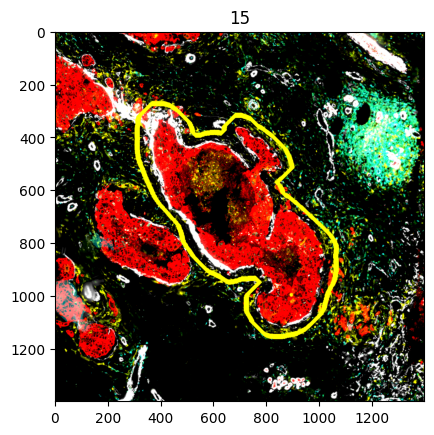

c3f440eb-55ef-4585-8272-647929ddfa85


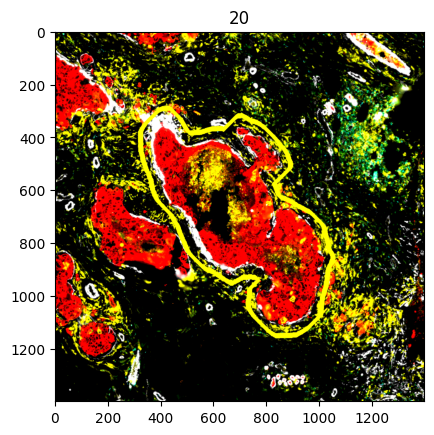

82c355bc-ee50-423d-9bb5-cf5fe192567f


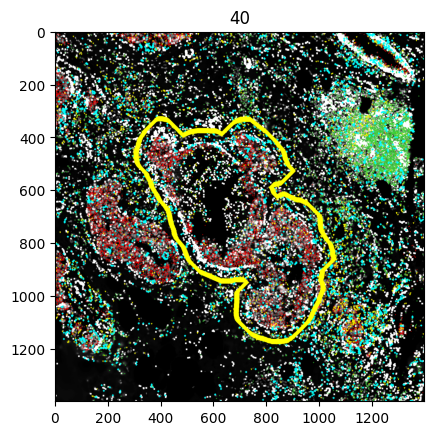

39a9a982-8b02-4a1e-a09f-ddf4a1ab9e06


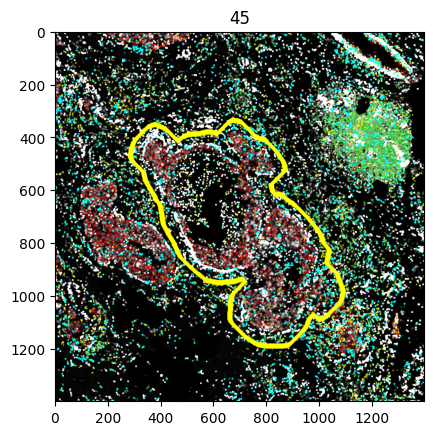

75331121-aff2-49bb-b158-371ad47d24d6


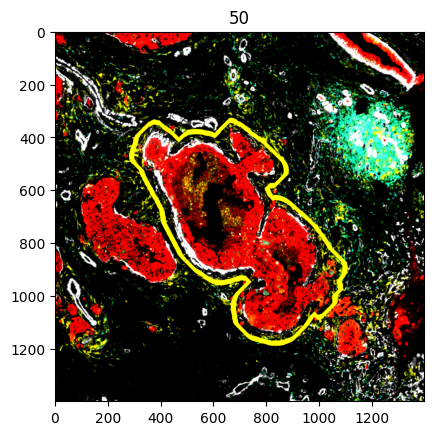

c18608c1-c6ed-4ea2-8bbc-940d62a109f6


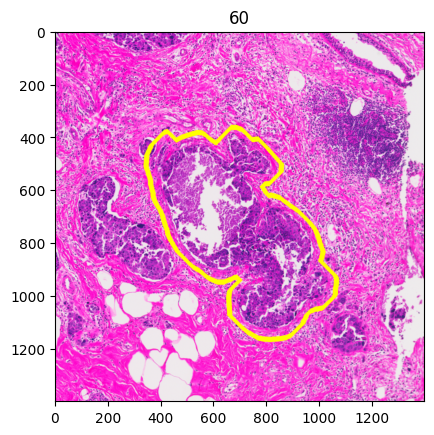

798bdf7c-7ac3-4e7b-96d8-73b440b88b13


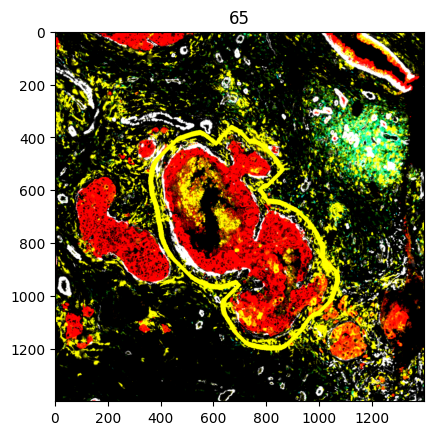

02404887-4c4f-4c41-a63f-adc8a8c519a5


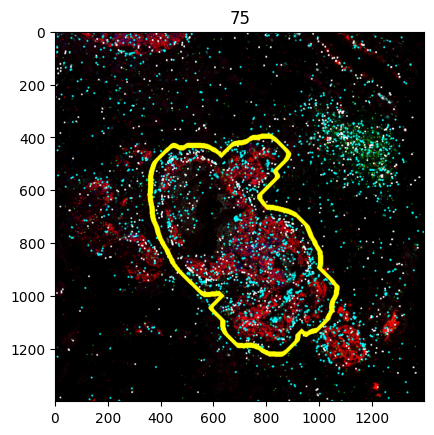

a50eff3f-d0a5-409b-92d4-eb3cf07cbadf


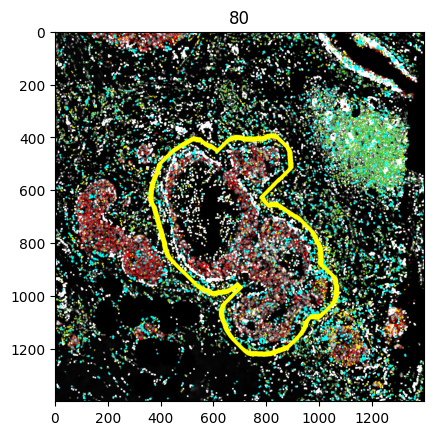

dcd20ad5-fe29-467a-8c66-00bf74d31e17


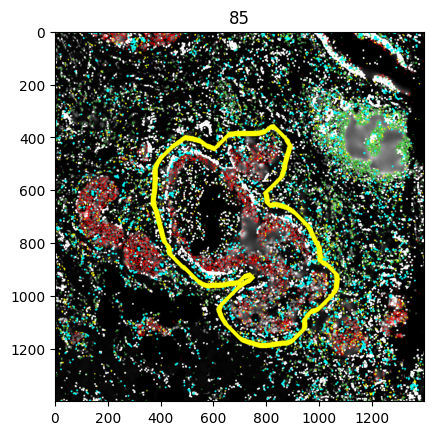

e4932d12-2a7e-4c0d-9c58-b773d8577a30


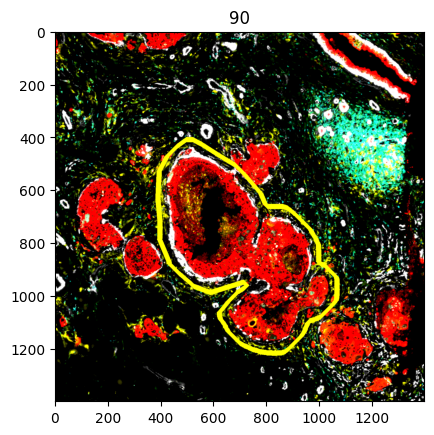

bbc8d158-839e-4b65-8a8c-36e933732b88


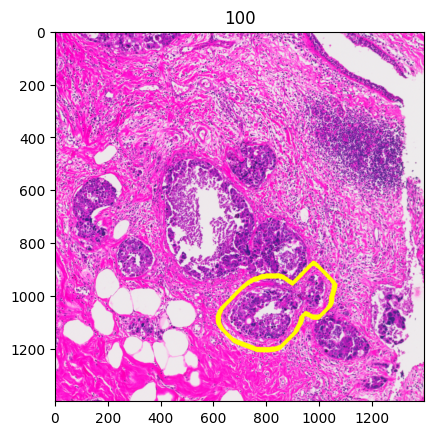

1000fd03-c370-4249-bb1e-15ea5ced685f


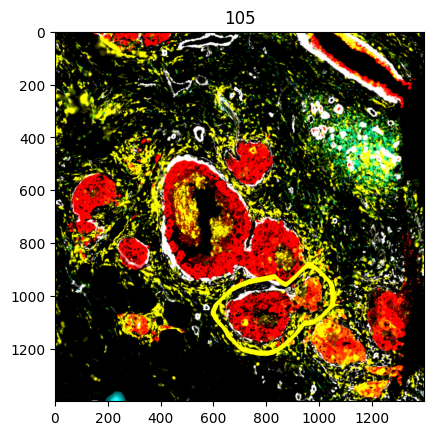

9b741c21-1ea5-4b83-abf9-e0b51cba93c1


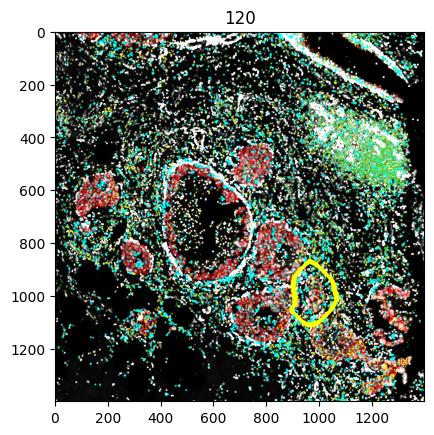

In [244]:

for rid, img in zip(keep, imgs):
    print(rid)
    region = region_id_to_region[rid]
    plt.imshow(img)
    plt.title(region['position'])
    plt.show()

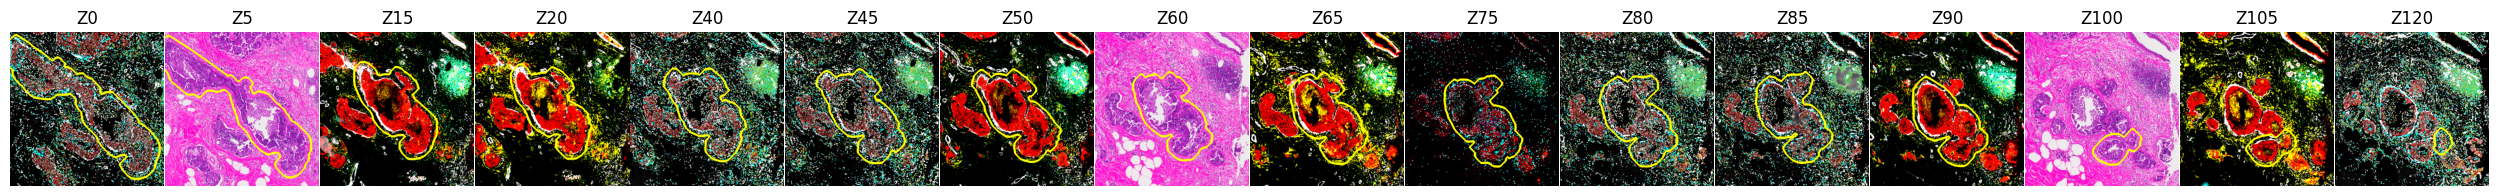

In [245]:
fig, axs = plt.subplots(ncols=len(imgs), figsize=(len(imgs) * 2, 2))

for rid, img, ax in zip(keep, imgs, axs):
    region = region_id_to_region[rid]
    position = region['position']
    
    ax.imshow(img)
    ax.set_axis_off()
    ax.set_aspect('equal')
    
    ax.set_title(f'Z{position}')
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(fig_dir / f'{roi}_all_images.svg', dpi=300)

In [246]:
case_to_pathology_annotations = {
    'HT397B1': {
        'roi1': {
            '28e4e782-02a6-42f5-8b12-5545c85edbc5': 'DCIS',
            '3331f2c7-2ed4-45e8-a9a2-ff1c9ec02a4a': 'IDC - partial',
            'c904b121-cc85-4e00-b350-5e6f21f8b64a': 'IDC'
        },
    },
    'HT206B1': {
        'roi1': {
            '78ddd8ed-908d-4b95-bdd0-f94cae4064d2': 'DCIS',
            'a15f9fc3-9a15-4bbc-a566-a9f62f83a6e2': 'IDC - partial',
            '132a3bbb-01de-49f6-a5f6-9abab2724546': 'IDC'
        },
        'roi2': {
            '9b6c4b7c-334e-44c1-913d-ad3a85c19037': 'DCIS',
            '39a9a982-8b02-4a1e-a09f-ddf4a1ab9e06': 'IDC - partial',
            '9b741c21-1ea5-4b83-abf9-e0b51cba93c1': 'IDC'
        },
    },
    'HT704B1': {
        'roi1': {
            'b28d28d2-098a-41aa-8a99-24f8c8753897': 'DCIS',
            '8f7fd7f0-ca13-43d5-a8a5-bc46e8f9b687': 'IDC - partial',
            'a4719551-76dd-4117-a82a-c086568f52f2': 'IDC'
        },
        'roi2': {
            'c2df8514-9463-481a-9b68-c81dd634bb9a': 'DCIS',
            '244c386c-93ac-4a5f-bf52-43dcce7a1388': 'IDC - partial'
        },
        'roi3': {
            'd9293330-df8b-43f9-8b88-2375643b60aa': 'DCIS'
        }
    },
    'HT891Z1': {
        'roi1': {
            '18073a83-5d22-4c2a-8cc8-e1b27a4de88e': 'Normal',
            'f478fe10-a739-49b6-a66b-e78a89114bb8': 'HG PIN',
            '5360344d-4cc6-495c-88c8-920d753afa68': 'GP3'
        },
        'roi2': {
            '42c61ec8-46dc-4e05-b951-77b036140cdd': 'Normal',
            '7a3535f1-c30c-40c1-9d31-24c2ee7e58f9': 'HG PIN',
            '9ddde78f-2e7b-4259-9bf9-efdd0a005b79': 'GP3'
        },
        'roi2-p2': {
            '406ac3bf-8609-4786-a1df-6540b4970cea': 'GP3',
            '62b6d19e-4d3b-46f5-b0dd-51028b4246b7': 'HG PIN',
            '9ddde78f-2e7b-4259-9bf9-efdd0a005b79': 'GP3'
        }
    },
    'HT913Z1': {
        'roi1': {
            'f3ae0453-4fd5-4160-8152-c3e4853df1f6': 'Normal',
            'a1c63d7a-d930-4836-b680-55014c4d272c': 'HG PIN',
            '5ea70ce2-e418-483d-89f6-eea5e0d721aa': 'Normal',
        },
        'roi1-p2': {
            'f3ae0453-4fd5-4160-8152-c3e4853df1f6': 'Normal',
            'a1c63d7a-d930-4836-b680-55014c4d272c': 'HG PIN',
            '0d40da4f-96d8-4c16-8865-5826b89c7cd8': 'GP3',
        },
    }
}

case_to_pathology_colors = {
    'HT397B1': {
        'IDC': [150, 29, 138],
        'IDC - partial': [171, 20, 12],
        'DCIS': [191, 128, 11],
        'Normal': [36, 117, 15]
    },
    'HT206B1': {
        'IDC': [150, 29, 138],
        'IDC - partial': [171, 20, 12],
        'DCIS': [191, 128, 11],
        'Normal': [36, 117, 15]
    },
    'HT704B1': {
        'IDC': [150, 29, 138],
        'IDC - partial': [171, 20, 12],
        'DCIS': [191, 128, 11],
        'Normal': [36, 117, 15]
    },
    'HT891Z1': {
        'GP3': [150, 29, 138],
        'HG PIN': [191, 128, 11],
        'Normal': [36, 117, 15]
    },
    'HT913Z1': {
        'GP3': [150, 29, 138],
        'HG PIN': [191, 128, 11],
        'Normal': [36, 117, 15]
    }
}

if case in ['HT206B1', 'HT397B1', 'HT704B1']:
    pathology_order = ['Normal', 'DCIS', 'IDC - partial', 'IDC'] # used for fold changes
else:
    pathology_order = ['Normal', 'HG PIN', 'GP3'] # used for fold changes


In [247]:
region_id_to_path = {}
annots = case_to_pathology_annotations[case][roi]
current = None
for k in keep:
    if k in annots:
        current = annots[k]
    region_id_to_path[k] = current
region_id_to_path

{'9b6c4b7c-334e-44c1-913d-ad3a85c19037': 'DCIS',
 '36007c49-205d-48ee-9b63-dfcb460e56b1': 'DCIS',
 'd3c2ad53-613a-4265-a031-db7285af2e45': 'DCIS',
 'c3f440eb-55ef-4585-8272-647929ddfa85': 'DCIS',
 '82c355bc-ee50-423d-9bb5-cf5fe192567f': 'DCIS',
 '39a9a982-8b02-4a1e-a09f-ddf4a1ab9e06': 'IDC - partial',
 '75331121-aff2-49bb-b158-371ad47d24d6': 'IDC - partial',
 'c18608c1-c6ed-4ea2-8bbc-940d62a109f6': 'IDC - partial',
 '798bdf7c-7ac3-4e7b-96d8-73b440b88b13': 'IDC - partial',
 '02404887-4c4f-4c41-a63f-adc8a8c519a5': 'IDC - partial',
 'a50eff3f-d0a5-409b-92d4-eb3cf07cbadf': 'IDC - partial',
 'dcd20ad5-fe29-467a-8c66-00bf74d31e17': 'IDC - partial',
 'e4932d12-2a7e-4c0d-9c58-b773d8577a30': 'IDC - partial',
 'bbc8d158-839e-4b65-8a8c-36e933732b88': 'IDC - partial',
 '1000fd03-c370-4249-bb1e-15ea5ced685f': 'IDC - partial',
 '9b741c21-1ea5-4b83-abf9-e0b51cba93c1': 'IDC'}

In [248]:
reg_dir = imaris_dir / 'regions'
reg_dir.mkdir(parents=True, exist_ok=True)

In [249]:
d = {
    'case_to_pathology_annotations': case_to_pathology_annotations,
    'case_to_pathology_colors': case_to_pathology_colors,
    'pathology_order': pathology_order,
    'region_id_to_pathology': region_id_to_path,
    'region_ids': keep,
    'dtypes': [region_id_to_region[k]['dtype'] for k in keep],
    'sids': [region_id_to_region[k]['sid'] for k in keep]
}
json.dump(d, open(reg_dir / f'{roi}_metadata.json', 'w'))

###### heatmaps

In [250]:
dti_to_cut = {
    'xenium_0': 2.5, # per 10 micron squared
    'xenium_1': 2.5,
    'xenium_combined': 2.5,
    'cosmx_0': 2.5,
    'vishd_0': .001,# per 2 micron squared,
    'visium_0': 2.,# per ~55 micron squared
}

In [251]:
def get_means_and_fracs(region_id_to_regions, paths, dtype_ident, mean_key='means', frac_key='fracs', dti_to_channel_idxs=None):
    results = []
    for path in paths:
        vals, fracs, densities, zs, other_vals, other_fracs, ids = [], [], [], [], [], [], []
        for k in path:
            if isinstance(k, int):
                region = region_id_to_region[label_to_region_id[k]]
            else:
                region = region_id_to_region[k]

            if dti_to_channel_idxs is not None:
                condition = 'dtype_ident' in region and region['dtype_ident'] in dti_to_channel_idxs
                idxs = dti_to_channel_idxs[region['dtype_ident']] if condition else None
            else:
                condition = 'dtype_ident' in region and region['dtype_ident'] == dtype_ident
                idxs = np.arange(len(region[mean_key]))
            if condition:
                vals.append(region[mean_key][idxs])
                fracs.append(region[frac_key][idxs])
                densities.append(region['densities'][idxs])
                zs.append(region['position'])
                
                rs = [x for x in region_id_to_region.values()
                      if x['position']==region['position'] and x['id']!=region['id']]
                if rs:
                    other_vals.append(np.stack([x[mean_key][idxs] for x in rs]))
                    other_fracs.append(np.stack([x[frac_key][idxs] for x in rs]))
                else:
                    other_vals.append(None)
                    other_fracs.append(None)
                
                ids.append(k)
                
        if vals:
            vals, fracs, densities = np.stack(vals), np.stack(fracs), np.stack(densities)
            pattern = 'd n -> n d'
            vals, fracs, densities = rearrange(vals, pattern), rearrange(fracs, pattern), rearrange(densities, pattern)
            results.append({
                'vals': vals,
                'fracs': fracs,
                'densities': densities,
                'other_vals': other_vals,
                'other_fracs': other_fracs,
                'zs': zs,
                'region_ids': ids
            })
    return results

import scipy
def get_correlations(vals, densities, default=0.):
    coors, pvals = [], []
    for row, density in zip(vals, densities):
        if density.max() <= dti_to_cut[dtype_ident]:
            coors.append(default)
            pvals.append(1.)
        else:
            if len(row) >= 2:
                r = scipy.stats.pearsonr(row, np.arange(len(row)))
                if not pd.isnull(r.pvalue):
                    coors.append(r.correlation)
                    pvals.append(r.pvalue)
                else:
                    coors.append(default)
                    pvals.append(1.)
            else:
                coors.append(default)
                pvals.append(1.)
    return np.asarray(coors), np.asarray(pvals)

def get_fold_changes(vals, annots, densities):
    df = pd.DataFrame(data=vals).T
    df['annot'] = annots
    density_df = pd.DataFrame(data=densities).T
    
    present = sorted(set([x for x in annots]), key=lambda x: pathology_order.index(x))
    print(present)
    pvals_data, statistic_data, fc_data, indices = [], [], [], []
    for i, annot1 in enumerate(present[:-1]):
        annot2 = present[i + 1]

        density = density_df[((df['annot']==annot1) | (df['annot']==annot2))].values
        
        xs = df[df['annot']==annot1].values[:, :-1].astype(float)
        ys = df[df['annot']==annot2].values[:, :-1].astype(float)
        
        statistic_row, pvals_row, fc_row = [], [], []
        for j in range(df.shape[1] - 1):
            if density[:, j].max() <= dti_to_cut[dtype_ident]:
                statistic_row.append(np.nan)
                pvals_row.append(np.nan)
                fc_row.append(np.nan)
            else:
                r = scipy.stats.ttest_ind(xs[:, j], ys[:, j])
                statistic_row.append(r.statistic)
                pvals_row.append(r.pvalue)
    
                a, b = xs[:, j].mean(), ys[:, j].mean()
                a, b = a + 1, b + 1
                fc = (b - a) / a
                fc_row.append(fc)
        
        pvals_data.append(pvals_row)
        statistic_data.append(statistic_row)
        fc_data.append(fc_row)
        
        indices.append(f'{annot1}_{annot2}')
    
    pvals_df = pd.DataFrame(data=pvals_data, index=indices)
    statistic_df = pd.DataFrame(data=statistic_data, index=indices)
    fc_df = pd.DataFrame(data=fc_data, index=indices)
    
    
    return fc_df, pvals_df, statistic_df

In [252]:
result_dir = imaris_dir / 'results'
result_dir.mkdir(parents=True, exist_ok=True)

do cell types

In [505]:
results = []
pool = []
for k in keep:
    region = region_id_to_region[k]
    if region['sid'] in sid_to_tiled_idx_ct:
        dti = sid_to_dtype_ident_ct[region['sid']]
        channels = dtype_ident_to_channels_ct[dti]
        pool += channels
pool = sorted(set(pool))

data = []
for k in keep:
    row = []
    region = region_id_to_region[k]
    if region['sid'] in sid_to_tiled_idx_ct:
        dti = sid_to_dtype_ident_ct[region['sid']]
        channels = dtype_ident_to_channels_ct[dti]
        row = [region['fracs_ct'][channels.index(p)] if p in channels else np.nan for p in pool]
    data.append(row)
ct_df = pd.DataFrame(data=data, columns=pool, index=keep)
ct_df


B cell     Basal  Club Cells  \
406ac3bf-8609-4786-a1df-6540b4970cea     0.0  0.001589    0.000216   
8cc2c7fe-be42-401d-b779-18b77ac156a3     NaN       NaN         NaN   
12c03edc-81d2-432f-9809-34efbed321d3     NaN       NaN         NaN   
13b32752-7032-4403-a855-75b2a2320799     NaN       NaN         NaN   
7ecb5ca3-161b-41da-bc89-1b64312c5840     NaN       NaN         NaN   
1198800c-9db2-4887-93c2-7f121df0468e     0.0  0.032445    0.007896   
5769757d-7e89-49a6-97e1-8a8419989506     NaN       NaN         NaN   
b5c5ff29-07e4-4ad1-a866-0e3bb78f4283     0.0  0.000000    0.000000   
c4380e8c-f7ad-4cfc-a4f3-ed430ec2c1bc     NaN       NaN         NaN   
227dad79-9f9d-465b-8543-0605892b42b3     NaN       NaN         NaN   
34b75982-a611-4e25-a583-bf10aafdd5bc     NaN       NaN         NaN   
dc5f3e39-0bea-41d3-b152-8d91c0e1ca17     0.0  0.000000    0.000000   
60111347-4dcd-465d-8537-82cb1cc5484e     NaN       NaN         NaN   
db3c0014-4c41-49db-9d74-e88f28041aee     NaN       NaN         NaN   
a29d8f43-06d4-4e0f-a059-8a4b9fbf959f     NaN       NaN         NaN   
f47c43ed-3e83-4a2f-86d6-aed44f1316c4     NaN       NaN         NaN   
46440f35-16e2-4395-9394-d5320861bf78     0.0  0.003139    0.005533   
acaef067-ff89-4676-b10c-6b5f4fd6560e     NaN       NaN         NaN   
cdef0207-f9b5-4a6b-bdf5-bde6df9f9282     0.0  0.004467    0.002230   
acaef067-ff89-4676-b10c-6b5f4fd6560e     NaN       NaN         NaN   
62b6d19e-4d3b-46f5-b0dd-51028b4246b7     0.0  0.001935    0.014898   
f8919fee-046b-436a-b728-94c76c3a153b     NaN       NaN         NaN   
686d4c90-0af6-467a-9134-39f483b04c28     NaN       NaN         NaN   
0070e7b1-9e6b-4cda-af13-b5d6238e97ed     NaN       NaN         NaN   
cbf8e855-8a31-4990-b144-064f544d3066     NaN       NaN         NaN   
e5d1214b-8f62-403c-833a-53032515931c     0.0  0.001745    0.007625   
24000119-0a82-45c1-8505-dc90901e014f     NaN       NaN         NaN   
cb76f6eb-6278-452d-bb4d-9726d650aec9     NaN       NaN         NaN   
f5c166e7-d9db-4bad-b55f-73a0f0799d60     NaN       NaN         NaN   
2a3facce-de6a-43a7-926b-8fbe42ed75b0     0.0  0.001193    0.019969   
69f28c38-daa2-4007-85ff-e5a1cf88e3eb     NaN       NaN         NaN   
0b7ef988-877b-4f6e-9b3f-3b7b33154774     0.0  0.006422    0.005339   
2feaaa28-3e77-4138-b9a4-0b75f68d2f64     NaN       NaN         NaN   
bcbe6b32-baba-4f9e-bf87-45e5f0660327     NaN       NaN         NaN   
d715e31a-7607-4ac3-b0c2-9456b9244140     NaN       NaN         NaN   
99087c7b-e996-40ed-b0f4-4286822192fa     NaN       NaN         NaN   
b6d1644d-743d-4cf4-9fa0-a43d95ea6baa     0.0  0.003313    0.001307   
bf6c40d9-bdf2-49a5-a3fe-b6e68d0b77c0     NaN       NaN         NaN   
386d888c-4246-46f5-b7a0-d0a763511097     NaN       NaN         NaN   
90116201-5a8a-4f73-be12-495d21dcf084     NaN       NaN         NaN   
142c7012-69e4-4f2a-b00b-9d350db99fd6     NaN       NaN         NaN   
68f55189-0e6f-41b1-9c65-2823226b8d7e     NaN       NaN         NaN   
511a2ee0-a928-47a5-a586-fab0fb648b99     NaN       NaN         NaN   
c3f12f7e-3df7-43fc-b275-503a6a37765c     NaN       NaN         NaN   
f1034984-615e-45a5-a4af-05f2fc4eb1b4     NaN       NaN         NaN   
92b53248-6da0-492a-9c0b-0c2a60946a0d     0.0  0.000000    0.000688   
2ef103e8-c8f1-4380-96f7-45f77427c077     NaN       NaN         NaN   
b536042f-2705-4627-be52-2465ff038195     NaN       NaN         NaN   
6d7255ad-dc1a-47c4-b99f-6fc5fc3f0772     NaN       NaN         NaN   
9ddde78f-2e7b-4259-9bf9-efdd0a005b79     NaN       NaN         NaN   
79e3353f-c2fe-4d54-8d30-a8a661cf61a1     NaN       NaN         NaN   
2db3f2d8-37ce-4ffa-81ea-7948b9af77ae     0.0  0.000000    0.000000   
c5facae8-79de-4842-b005-ad9e9d23747e     NaN       NaN         NaN   

                                      Endothelial  Epithelial  Fibroblast  \
406ac3bf-8609-4786-a1df-6540b4970cea     0.004869    0.931026    0.002116   
8cc2c7fe-be42-401d-b779-18b77ac156a3     0.017677    0.678796    0.023112   
12c03edc-81d2-432f-9809-34

In [506]:
ct_df.index.name = 'region_id'
ct_df.to_csv(result_dir / f'{roi}_cell_type_fracs.txt.gz', sep='\t')

In [155]:
dtype_ident_to_channels.keys()

dict_keys(['xenium_0', 'he_0', 'multiplex_0', 'multiplex_1', 'xenium_1', 'cosmx_0'])

In [253]:
# dtype_ident = 'xenium_0'
# dtype_ident = 'xenium_1'
dtype_ident = 'cosmx_0'
# dtype_ident = 'vishd_0'
# dtype_ident = 'visium_0'

exp_delta_cut = .0
channels = dtype_ident_to_channels[dtype_ident]
print(len(channels))

result = get_means_and_fracs(region_id_to_region, [keep], dtype_ident)[0]
result.keys()

1000


dict_keys(['vals', 'fracs', 'densities', 'other_vals', 'other_fracs', 'zs', 'region_ids'])

In [254]:
# # run this to merge dti's
# dtype_ident = 'xenium_combined'
# root = dtype_ident.split('_')[0]
# dtis = [x for x in dtype_ident_to_channels.keys() if root in x]
# assert len(dtis) > 1

# all_channels = [set(dtype_ident_to_channels[dti]) for dti in dtis]
# channels = sorted(set.intersection(*all_channels))
# assert len(channels) > 0

# common_dtis_to_idxs = {}
# for dti in dtis:
#     idxs = np.asarray([dtype_ident_to_channels[dti].index(c) for c in channels])
#     common_dtis_to_idxs[dti] = idxs

# result = get_means_and_fracs(region_id_to_region, [keep], dtype_ident, dti_to_channel_idxs=common_dtis_to_idxs)[0]
# result.keys()

In [255]:
result['vals'].shape

(1000, 1)

In [256]:
coors, pvals = get_correlations(result['vals'], result['densities'])
vals, fracs, densities, zs, other_vals, other_fracs = result['vals'], result['fracs'], result['densities'], result['zs'], result['other_vals'], result['other_fracs']
annots = [region_id_to_path[rid] for rid in result['region_ids']]
fc_df, pvals_df, statistic_df = get_fold_changes(vals, annots, densities)
fc_df.columns = channels
pvals_df.columns = channels
statistic_df.columns = channels
fc_df

['IDC - partial']


ValueError: Length mismatch: Expected axis has 0 elements, new values have 1000 elements

In [257]:
corrs_df = pd.DataFrame.from_dict({
    'correlation': coors,
    'pvalue': pvals
})
corrs_df.index = channels
corrs_df

correlation  pvalue
AATK            0.0     1.0
ABL1            0.0     1.0
ABL2            0.0     1.0
ACACB           0.0     1.0
ACE             0.0     1.0
...             ...     ...
XKR4            0.0     1.0
YBX3            0.0     1.0
YES1            0.0     1.0
ZBTB16          0.0     1.0
ZFP36           0.0     1.0

[1000 rows x 2 columns]

In [259]:
exp_df = pd.DataFrame(data=vals, columns=result['region_ids'], index=channels).T
exp_df

AATK      ABL1      ABL2     ACACB  \
02404887-4c4f-4c41-a63f-adc8a8c519a5  1.642032  1.332957  1.956063  1.008483   

                                           ACE     ACKR1     ACKR3     ACKR4  \
02404887-4c4f-4c41-a63f-adc8a8c519a5  1.476726  1.537603  1.154428  1.717627   

                                          ACP5     ACTA2  ...     WNT7A  \
02404887-4c4f-4c41-a63f-adc8a8c519a5  0.848188  1.077539  ...  1.226962   

                                         WNT7B     WNT9A      XBP1    XCL1/2  \
02404887-4c4f-4c41-a63f-adc8a8c519a5  0.923363  1.577802  1.751176  1.971223   

                                          XKR4      YBX3      YES1   ZBTB16  \
02404887-4c4f-4c41-a63f-adc8a8c519a5  1.623107  1.899466  1.597959  0.97564   

                                         ZFP36  
02404887-4c4f-4c41-a63f-adc8a8c519a5  2.302437  

[1 rows x 1000 columns]

In [162]:
pvals_df

AATK  ABL1  ABL2  ACACB  ACE  ACKR1  ACKR3  ACKR4  ACP5  ACTA2  ...  \
DCIS_IDC   NaN   NaN   NaN    NaN  NaN    NaN    NaN    NaN   NaN    NaN  ...   

          WNT7A  WNT7B  WNT9A  XBP1  XCL1/2  XKR4  YBX3  YES1  ZBTB16  ZFP36  
DCIS_IDC    NaN    NaN    NaN   NaN     NaN   NaN   NaN   NaN     NaN    NaN  

[1 rows x 1000 columns]

In [163]:
means = fc_df.mean(0).values
null_mask = pd.isnull(means)
means = means[~null_mask]
idxs = np.argsort(means)
ordered = np.asarray(channels)[~null_mask][idxs]
ordered

array(['COL9A2', 'COL9A3', 'KRT15', 'BMP2', 'CXCL14', 'FZD8', 'CDKN1A',
       'HEY1', 'KIT', 'IGFBP5', 'SNAI1', 'NRXN3', 'KRT16', 'FZD6',
       'FGFR3', 'POU5F1', 'S100P', 'PLCG1', 'C5AR2', 'LIF', 'VEGFB',
       'COX4I2', 'NPPC', 'MXRA8', 'IFNL2/3', 'SMAD3', 'TNFSF13B', 'WNT5B',
       'TGFBI', 'CXCR5', 'PTGIS', 'CD3E', 'NFKBIA', 'JAG1', 'IGF1',
       'EPHA2', 'SNAI2', 'DUSP5', 'CST7', 'PNOC', 'OSM', 'TNFRSF21',
       'FFAR4', 'DUSP4', 'HCK', 'TNFSF9', 'IL11RA', 'PLAC9', 'PDGFRA',
       'ITGB5', 'BMP4', 'TFEB', 'CDH19', 'CXCL17', 'FGFR1', 'S100B',
       'EFNA1', 'G0S2', 'ADGRF5', 'ACVR1', 'IL7', 'CEACAM1', 'FAM30A',
       'CCL3/L1/L3', 'TNNC1', 'VEGFA', 'CD79A', 'KRT86', 'SRC', 'PTK6',
       'SLC2A1', 'GATA3', 'GADD45B', 'PLD3', 'CTSG', 'CD44', 'ETV5',
       'BCL2L1', 'BRAF', 'NDUFA4L2', 'ICOSLG', 'IL12A', 'BASP1',
       'MAP1LC3B/2', 'IL17D', 'DPT', 'CLOCK', 'PDCD1', 'TNXA/B', 'IL20RA',
       'IL10', 'PTGDR2', 'PSD3', 'B3GNT7', 'BAG3', 'TNFRSF11B', 'RAMP1',
       'FGF9', 

In [164]:
len(ordered)

941

In [165]:
# idxs = np.argsort(coors)
# m = np.asarray([x > .2 for x in fracs[idxs].max(-1)])
# m &= pvals[idxs] < p_value_cut
# idxs = idxs[m]

# ordered = np.asarray(channels)[idxs]

# ordered

In [166]:
n = 30

source = pd.DataFrame(data=vals.T, columns=channels, index=zs)
source = source[ordered]

source = source[[c for c in source.columns if 'MT-' not in c]] # get rid if MT genes

if source.shape[1] > n * 2:
    source = pd.concat((source.iloc[:, :n], source.iloc[:, -n:]), axis=1)

# data = vals[idxs]
# data -= data.min(1, keepdims=True)
# source = pd.DataFrame(data=data.T, columns=ordered, index=zs)
source

COL9A2    COL9A3     KRT15      BMP2    CXCL14      FZD8    CDKN1A  \
75  4.455430  4.353110  2.220473  3.939985  5.963997  3.247311  3.540484   
75  1.174818  1.382562  0.451122  1.252845  2.197199  1.056509  1.203912   

        HEY1       KIT    IGFBP5  ...     EPCAM  HSP90AB1       MYC   HSP90B1  \
75  3.766776  6.156555  3.033133  ...  0.977535  1.684951  1.712599  1.436974   
75  1.319510  2.576469  1.111432  ...  1.526212  2.446680  2.519587  2.192026   

      NOTCH1    S100A2    HMGCS1     MKI67    IGFBP7      KRT4  
75  1.024724  1.668298  1.350151  1.333497  0.498004  1.943108  
75  1.664335  2.671895  2.242346  2.295884  1.132984  3.563664  

[2 rows x 60 columns]

In [167]:
fig_dir

PosixPath('/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/figures')

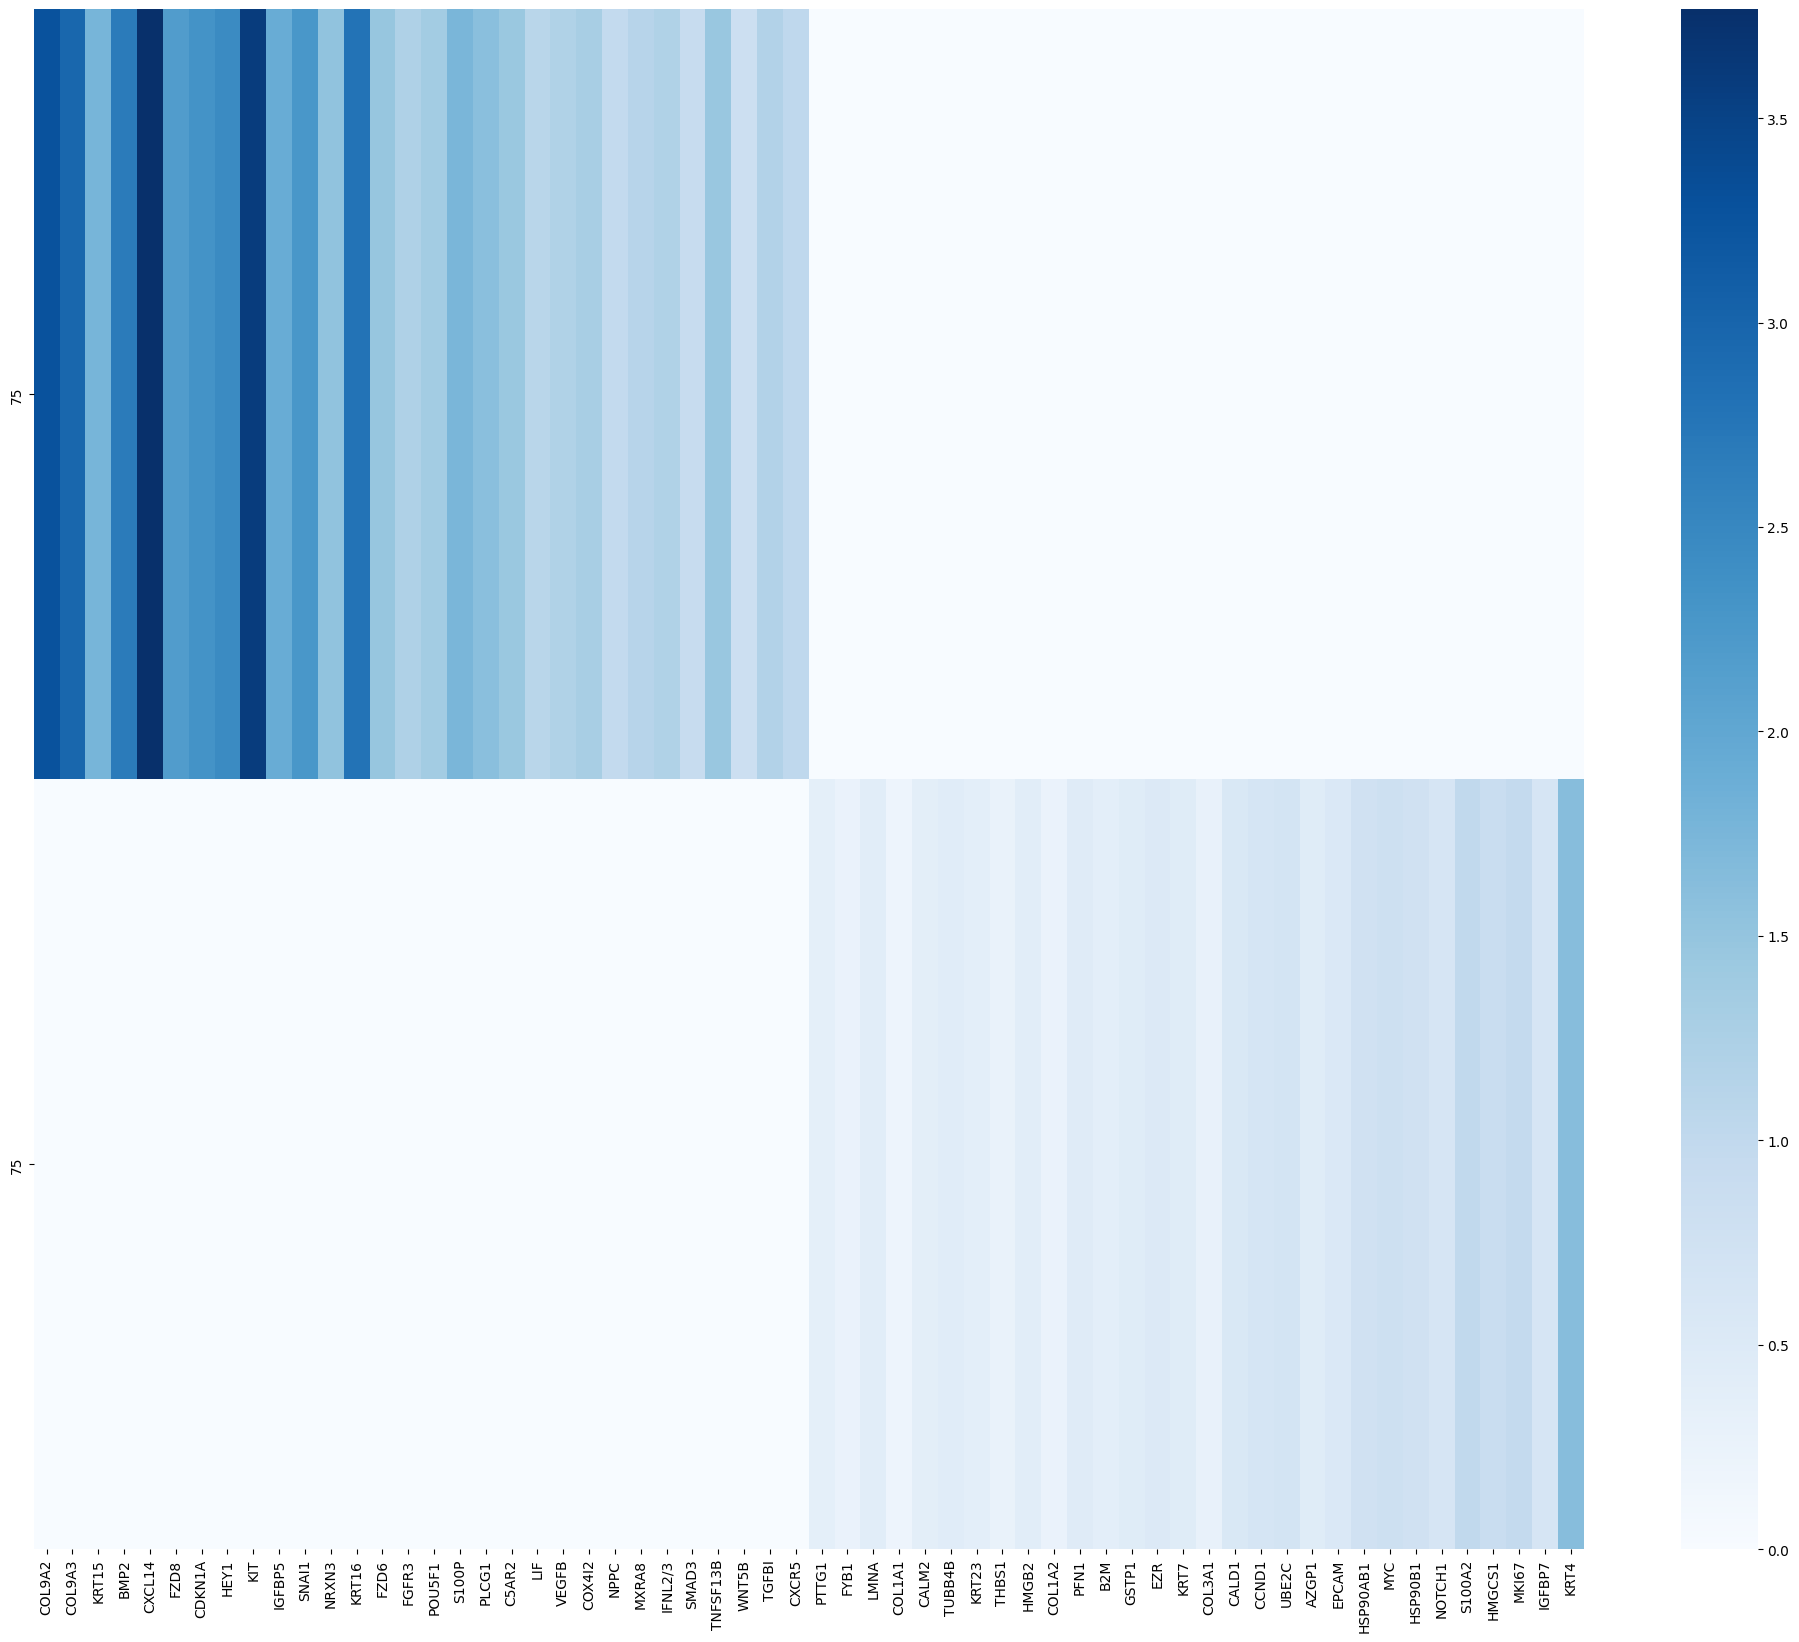

In [168]:
fig, ax = plt.subplots(figsize=(25, 20))
# vmax = 4.
vmax = None
sns.heatmap(source - source.min(0), cmap='Blues', vmax=vmax)
plt.savefig(fig_dir / f'{roi}_{dtype_ident}_gene_heatmap.svg')

/data/estorrs/miniconda3/envs/mushroom_v2/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/data/estorrs/miniconda3/envs/mushroom_v2/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


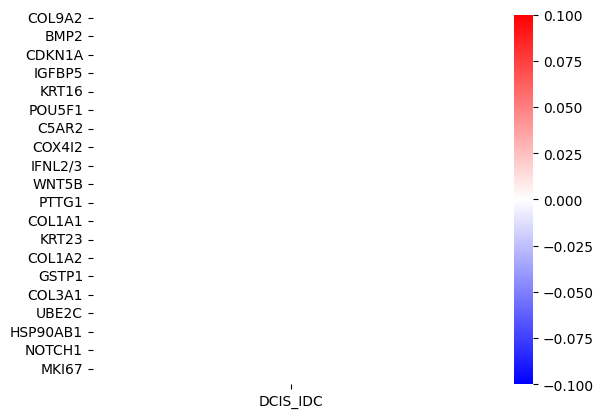

In [169]:
df = statistic_df.T.loc[source.columns]
divnorm = TwoSlopeNorm(vmin=df.values.min(), vcenter=0., vmax=df.values.max())
sns.heatmap(df, cmap='bwr', norm=divnorm)
plt.savefig(fig_dir / f'{roi}_{dtype_ident}_gene_heatmap_statistic.svg')

/data/estorrs/miniconda3/envs/mushroom_v2/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


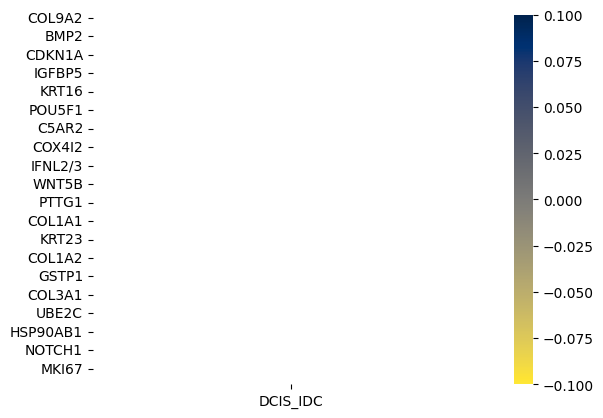

In [170]:
sns.heatmap(pvals_df.T.loc[source.columns], cmap='cividis_r', vmin=0)
plt.savefig(fig_dir / f'{roi}_{dtype_ident}_gene_heatmap_pvals.svg')

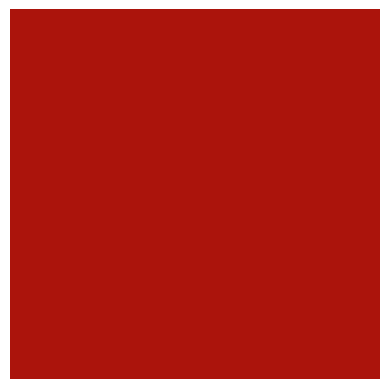

In [260]:
rids = result['region_ids']
tiles = []
for rid in rids:
    annot = region_id_to_path[rid]
    color = case_to_pathology_colors[case][annot]
    tile = np.zeros((50, 50, 3), dtype=np.uint8)
    tile[...] = color
    tiles.append(tile)
bar = np.concatenate(tiles, axis=1)
plt.imshow(bar)
plt.axis('off')
plt.savefig(fig_dir / f'{roi}_{dtype_ident}_gene_heatmap_pathology.svg')

In [261]:
exp_df.index.name = 'region_id'
exp_df.to_csv(result_dir / f'{roi}_{dtype_ident}_expression.txt.gz', sep='\t')

In [262]:
corrs_df.index.name = 'gene'
corrs_df.to_csv(result_dir / f'{roi}_{dtype_ident}_correlation.txt.gz', sep='\t')

In [263]:
fc_df.index.name = 'transition_id'
fc_df.to_csv(result_dir / f'{roi}_{dtype_ident}_fc.txt.gz', sep='\t')

In [264]:
pvals_df.index.name = 'transition_id'
pvals_df.to_csv(result_dir / f'{roi}_{dtype_ident}_pvals.txt.gz', sep='\t')

In [265]:
statistic_df.index.name = 'transition_id'
statistic_df.to_csv(result_dir / f'{roi}_{dtype_ident}_statistics.txt.gz', sep='\t')

In [266]:
d = {
    'exp_delta_cut': exp_delta_cut,
#     'vmax': vmax,
    'channels': channels
}
json.dump(d, open(result_dir / f'{roi}_{dtype_ident}_metadata.json', 'w'))

In [267]:
result_dir

PosixPath('/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/imaris/rois/results')

In [369]:
# gene = 'ALDH1A3'
# r1, r2, c1, c2 = [x // tiling_size for x in [R1, R2, C1, C2]]
# for sid, tiled in sid_to_tiled.items():
#     dtype = sid_to_dtype[sid]
#     rgb = sid_to_rgb[sid]
#     z = sid_to_z[sid]
#     m = z_to_regions_mask[z]
#     mm = skimage.morphology.binary_dilation(m)
#     m = mm ^ m
    
#     if dtype == 'xenium':
#         fig, ax = plt.subplots(ncols=2)
#         x = tiled[dtype_to_channels[dtype].index(gene)]
#         x = np.stack([x, x, x], -1)
#         x[m] = [x.max(), 0, 0]
#         x = x[r1:r2, c1:c2]
#         x /= x.max()
# #         x = utils.rescale(x, size=rgb.shape[:2], dim_order='h w c', target_dtype=x.dtype)
#         print(x.shape, m.shape)
# #         x[m] = [1, 0, 0]
#         ax[0].imshow(x)
#         ax[0].set_title(z)
#         ax[1].imshow(rgb)
#         plt.show()

In [203]:
imaris_dir

PosixPath('/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/imaris/rois')

In [465]:
fig_dir

PosixPath('/data/estorrs/mushroom/data/projects/submission_v1/HT891Z1/figures')